# Forecasting Median House Prices in the PNW
- **Student Name:** Serena Quiroga
- **Program:** Flatiron Online Data Science (Self-Paced), Module 4 Project
- **Date:** November 27, 2019
- **Blog Post Link:** https://squiroga8.github.io/the_time_business_understanding_saved_everything
- **Instructor:** Jeff Herman

# **Project Overview**

## Project Background:

Within this notebook, I will be forecasting real estate prices of various zip codes using data from Zillow to make final recommendations to a fictitious real-estate investment firm, called Redwood Real Estate. Zillow is one of the top real estate marketplaces, providing accurate housing data to home buyers and sellers alike. The Zillow dataset contains historical sales price data back to 1996 for the United States. 

For the purposes of this project, I have defined the following information regarding this fictional firm and their interests:
- Redwood Real Estate (hereafter referred to as Redwood) invests in residential real estate markets across the Pacific Northwest, with a previous focus on rural areas in Oregon and Washington state.
- Redwood is *now* seeking to invest in **metro areas in Oregon and Washington only.**
- Redwood is weary of areas where housing prices are surging, as they are a family-owned business that identifies as more *risk adverse* with a focus on ethical and shared growth. 
- Redwood's business values include *sustainable investments, establishing ties with local community, and responsible real estate appraisal practices.* They want to **avoid contributing to what they see as growing economic inequality.**
- Redwood's slogan is: **"Let's grow together."**

I am seeking to implement time series analysis and modeling, guided by data-driven decisions and a strong business understanding, to identify the top 5 zip codes for Redwood to invest.  

### **Goal: To identify the best 5 zip codes to invest in using Time-Series Modeling techniques.**

## Project Parameters & Approach

- **Data Used:** Zillow Research Data https://www.zillow.com/research/data/ (contained as a csv in this repo as well).

- **Models and Tests Used:**
    - Stationarity checks (rolling statistics and augmented Dickey-Fuller Test)
    - Seasonal Decomposition
    - SARIMAX and ARIMA Modeling
    - Model evaluation techniques (AIC, MSE, model summaries, and model diagnostics)

- **Approach:**
    - Establish initial Business Understanding
    - Conduct additional research related to Business Understanding
    - Obtain data
    - Select subset of data based off of business understanding
    - Update business understanding based off of data understanding and initial exploration
    - De-trend and control for seasonality - stationarity 
    - Model with parameter tuning
    - Forecast
    - Evaluate and make recommendations

### Libraries Used

In [1]:
# all libraries/packages used are listed here
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
plt.style.use('seaborn-dark-palette')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')


## Project Approach: CRISP-DM

I am using the **CRoss-Industry Standard Process for Data Mining (CRISP-DM)** for this project. I chose this data science process framework largely due to weight given to the Business Understanding, which for this project has been detailed in the project parameter assumptions and project background section. As shown below, the Business Understanding is tied in with Data Understanding and Evaluating findings.

Each step in the framework is accompanied with guiding questions, borrowed from the Flatiron Learn.co materials.

<img src="CRISP-DM_approach.png" alt="Drawing" style="width: 400px;"/>

# **Business Understanding**

Given Redwood's interests and business values, the following are key elements to the business understanding of this analysis:
- Redwood is seeking to invest in metro areas in the Pacific Northwest, specifically Oregon and Washington, where they can establish long-term ties to the local community.
    - *The data subset focuses exclusively on zip codes in the Pacific Northwest*
    - *Remove zip codes that are not part of Metro areas, based on `Metro` column.*
- Redwood  does not want to invest in areas considered to be housing bubbles, where housing prices have surged to quickly, or in areas with high volatility.
    - *Remove areas where housing price to income ratio is too high.*
- Redwood would like to invest in areas that have shown a capacity for recovery since the 2008 financial crisis
    - *Identify areas with highest growth from 2008-2018.*
    - *Time frame is slightly flexible, with a preference on data from last 12-14 years so as to take into account the 2008 financial crisis.* Depending on missing data, earliest time frame can be adjusted to not include full range from 1996 onwards.
- Redwood is slightly risk adverse and wants to avoid areas with high variability.
    - *Identify areas with lowest volatility (std) across select time frame.*

# **Step 1: Data Understanding**

## *Guiding Questions:*
"During this stage, we'll aim to get a solid understanding of the data needed to complete the project. This step includes both understanding where our data is coming from, as well as the information contained within the data.

Consider the following questions when working through this stage:
- What data is available to us? Where does it live? Do we have the data, or can we scrape/buy/source the data from somewhere else?
- Who controls the data sources, and what steps are needed to get access to the data?
- What is our target?
- What predictors are available to us?
- What data types are the predictors we'll be working with?
- What is the distribution of our data?
- How many observations does our dataset contain? Do we have a lot of data? Only a little?
- Do we have enough data to build a model? Will we need to use resampling methods?
- How do we know the data is correct? How is the data collected? Is there a chance the data could be wrong?"


In [2]:
# Load the data
orig_data = pd.read_csv('zillow_data.csv')
print(orig_data.info())
orig_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB
None


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
orig_data.RegionName.nunique()

14723

A few observations:
- `RegionName` represent the zip codes - of which there are 14723 unique zip codes 
- Monthly dates are represented as their own columns
- `Metro` columns has many null values, likely indicating zip codes that are not part of a metro area.

## 1st Level Subset - Based on State

In [4]:
# Identify states in Pacific Northwest that Redwood wants to invest in
pnw_states = ['OR', 'WA']

In [5]:
# Subset of data for pnw states
pnw_subset = orig_data[orig_data.State.isin(pnw_states)]
pnw_subset.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
67,99534,98052,Redmond,WA,Seattle,King,68,219700.0,219900.0,220200.0,...,843400,852500,861700,873200,886000,900500,915200,924700,929300,930600
135,99142,97229,Portland,OR,Portland,Multnomah,136,209800.0,209700.0,210700.0,...,561800,563100,565600,567700,569200,570000,570200,571500,573800,574800
143,99500,98012,Bothell,WA,Seattle,Snohomish,144,200300.0,199200.0,198100.0,...,537800,544900,553500,562500,569500,577700,584500,591400,604000,616000
161,99563,98103,Seattle,WA,Seattle,King,162,175700.0,175900.0,176300.0,...,800000,808000,817100,828500,842300,856700,869300,876500,880800,882800
180,100179,99301,Pasco,WA,Kennewick,Franklin,181,92400.0,91900.0,91400.0,...,205400,207500,210100,212600,214200,216000,217600,218300,218100,217600


In [6]:
pnw_subset.State.value_counts()

WA    341
OR    224
Name: State, dtype: int64

### Append Income levels per Zip

I am appending income data (mean and median income from 2006-2010), using data I downloaded from this site: https://www.psc.isr.umich.edu/dis/census/Features/tract2zip/

The income data is available in this repo as a csv.

In [7]:
# load median and mean income data per zip from 2006-2010
income_df = pd.read_csv('MedianIncome_ZIP-3.csv')
income_df.head()

,Zip,Median,Mean,Pop
0,1001,"56,663","66,688","16,445"
1,1002,"49,853","75,063","28,069"
2,1003,"28,462","35,121","8,491"
3,1005,"75,423","82,442","4,798"
4,1007,"79,076","85,802","12,962"


In [8]:
# join the income and housing dataframes using left join on pnw's zip code info
df = pnw_subset.merge(income_df, how="left", left_on="RegionName", right_on="Zip")

#Rename income columns
df.rename(columns={'Median':'MedianIncome20062010', 'Mean':'MeanIncome20062010'}, inplace=True)
#Drop the redundant "Zip" columns
df.drop('Zip', inplace=True, axis=1)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,MedianIncome20062010,MeanIncome20062010,Pop
0,99534,98052,Redmond,WA,Seattle,King,68,219700.0,219900.0,220200.0,...,873200,886000,900500,915200,924700,929300,930600,"93,173","111,386","58,442"
1,99142,97229,Portland,OR,Portland,Multnomah,136,209800.0,209700.0,210700.0,...,567700,569200,570000,570200,571500,573800,574800,"98,462","117,097","43,345"
2,99500,98012,Bothell,WA,Seattle,Snohomish,144,200300.0,199200.0,198100.0,...,562500,569500,577700,584500,591400,604000,616000,"87,772","96,953","51,136"
3,99563,98103,Seattle,WA,Seattle,King,162,175700.0,175900.0,176300.0,...,828500,842300,856700,869300,876500,880800,882800,"69,942","85,947","45,911"
4,100179,99301,Pasco,WA,Kennewick,Franklin,181,92400.0,91900.0,91400.0,...,212600,214200,216000,217600,218300,218100,217600,"48,363","58,392","68,191"


In [9]:
df[["MedianIncome20062010","MedianIncome20062010", "Pop"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565 entries, 0 to 564
Data columns (total 3 columns):
MedianIncome20062010    560 non-null object
MedianIncome20062010    560 non-null object
Pop                     560 non-null object
dtypes: object(3)
memory usage: 17.7+ KB


In [10]:
# to operate on multiple columns, put them in a list like so
cols = ["MedianIncome20062010","MeanIncome20062010", "Pop"]

# remove commas so that we can convert data in appended columns as numeric data
df[cols] = df[cols].replace({',': ''}, regex=True)

In [11]:
# Change new columns to numeric data
df[["MedianIncome20062010","MeanIncome20062010", "Pop"]] = df[["MedianIncome20062010","MeanIncome20062010", "Pop"]].apply(pd.to_numeric)


## 2nd Level Subset - Focus on Metro Areas only

Redwood is only interested in Metro areas, so we will remove zip codes without a Metro identification.

In [12]:
# remove all rows without a Metro designation
df.Metro.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565 entries, 0 to 564
Columns: 275 entries, RegionID to Pop
dtypes: float64(222), int64(49), object(4)
memory usage: 1.2+ MB


In [13]:
# group by metros to calculate mean of median housing prices between 2006 and 2010
# then create a ratio column to see how mean housing compares with mean income a
metros = df.groupby(['Metro']).mean()

### Mean Income to Mean Housing Prices (2006-2010) cut-off

We will now look to identify metros that satisfy Redwood's objective of avoiding areas with growing inequality. we will create columns for the mean of median housing prices and the mean income levels from 2006-2010 data only, and then examine the ratios of housing prices to income. With some industry research and an exploration of the underlying data, we will decide on a cut-off point for high ratios.

In [14]:
# create a new column for taking the mean of median housing prices from 2006 to 2010
col = metros.loc[: , '2006-01':'2010-12']
metros['Mean20062010'] = col.mean(axis=1)

In [15]:
# make new column for ratio of housing mean of medians and mean income from 2006-2010
metros['HousingIncomeRatio'] = metros['Mean20062010'] / metros['MeanIncome20062010']
metros.head()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-12,2018-01,2018-02,2018-03,2018-04,MedianIncome20062010,MeanIncome20062010,Pop,Mean20062010,HousingIncomeRatio
Metro,,,,,,,,,,,,,,,,,,,,,
Aberdeen,99866.500000,98554.700000,10259.500000,95910.000000,95840.000000,95800.000000,95760.000000,95710.000000,95700.000000,95700.000000,...,168050.000000,171220.000000,174520.000000,177740.000000,180520.000000,42620.600000,53841.900000,7130.800000,153400.166667,2.849085
Albany,99223.250000,97361.375000,7880.875000,90312.500000,90637.500000,90862.500000,91025.000000,91162.500000,91337.500000,91575.000000,...,229837.500000,230575.000000,232687.500000,237562.500000,242437.500000,49488.500000,59721.750000,11972.875000,174323.958333,2.918936
Astoria,99092.750000,97124.250000,8942.000000,126250.000000,126900.000000,127500.000000,128075.000000,128675.000000,129225.000000,129800.000000,...,329075.000000,328775.000000,327775.000000,327275.000000,327950.000000,40645.750000,54620.750000,7309.250000,310077.083333,5.676910
Bellingham,99660.615385,98250.538462,7703.538462,133807.692308,134676.923077,135584.615385,136515.384615,137461.538462,138476.923077,139615.384615,...,331992.307692,333353.846154,336761.538462,343023.076923,347884.615385,52205.384615,64351.000000,15242.692308,273914.358974,4.256567
Bend,192892.000000,97723.857143,4449.000000,130428.571429,130714.285714,130985.714286,131285.714286,131685.714286,132285.714286,133257.142857,...,361957.142857,362842.857143,365528.571429,371371.428571,376271.428571,49924.166667,61953.666667,18660.666667,271025.000000,4.374640


**Given the business understanding that Redwood is interested in avoiding housing bubbles and not contributing to growing inequality, we are establishing a cut-off for "safe" housing-price-to-income-ratios by metro area based on 2006-2010 mean data.**

Let's first explore the data and see what the distributions look like before selecting the cut-off threshold.  For industry standards, below is some background materials:

**Industry Research**:
"The rule of thumb long used by real estate agents and homebuyers is that you can afford a house if its price is equivalent to roughly 2.6 years of your household income. That ratio is based on historical nationwide averages under healthy economic conditions."
*sources:* https://www.citylab.com/equity/2018/05/where-the-house-price-to-income-ratio-is-most-out-of-whack/561404/ and https://www.forbes.com/sites/zillow/2013/04/16/high-home-price-to-income-ratios-hiding-behind-low-mortgage-rates/#68640ead3a59

In [16]:
# check if there are any null values
metros['HousingIncomeRatio'].isnull().sum()

1

In [17]:
# examine the null values more closely
null_columns=metros.columns[metros.isnull().any()]
metros[null_columns].isnull().sum()
print(metros[metros.isnull().any(axis=1)][null_columns].head())

                     1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  \
Metro                                                                       
Hermiston-Pendleton      NaN      NaN      NaN      NaN      NaN      NaN   
Pullman                  NaN      NaN      NaN      NaN      NaN      NaN   

                     1996-10  1996-11  1996-12  1997-01  ...        2010-11  \
Metro                                                    ...                  
Hermiston-Pendleton      NaN      NaN      NaN      NaN  ...  125366.666667   
Pullman                  NaN      NaN      NaN      NaN  ...            NaN   

                           2010-12        2011-01        2011-02   2011-03  \
Metro                                                                        
Hermiston-Pendleton  124866.666667  124433.333333  123633.333333  122800.0   
Pullman                        NaN            NaN            NaN       NaN   

                           2011-04        2011-05        2011

While we will deal with null values in a more concerted effort later, in this case we will remove Pullman metro from our metros df as it is missing all housing price info between the crucial years for out decision cut-off.

In [18]:
# Drop Pullman from metros df
metros.drop(["Pullman"], inplace=True)

Let's visualize are newly created ratios per metro.

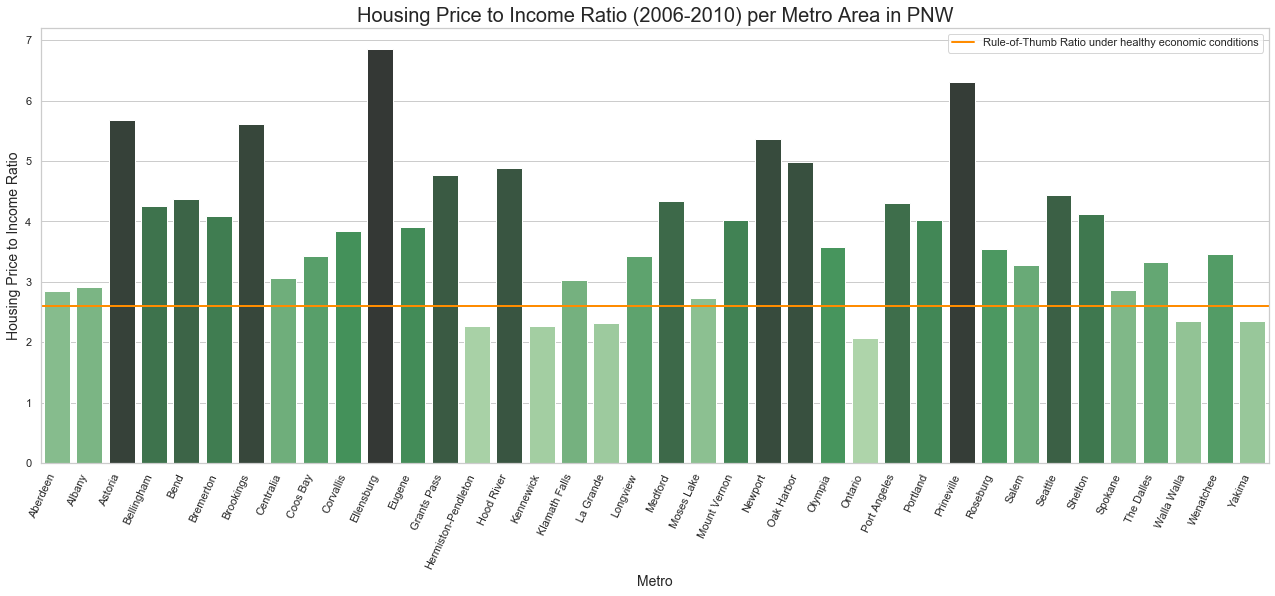

In [19]:
# Plot all metros and their housing price to income ratios
pal = sns.color_palette("Greens_d", len(metros))
rank = metros['HousingIncomeRatio'].argsort().argsort()
plt.figure(figsize=(22,8))
sns.barplot(x=metros.index, y=metros.HousingIncomeRatio, palette=np.array(pal[::-1])[rank])
plt.xticks(rotation=65, ha="right")
plt.xlabel("Metro", fontsize=14)
plt.ylabel("Housing Price to Income Ratio", fontsize=14)
# Add a horizontal line for the industry standard ratio
plt.axhline(y=2.6, color="darkorange", lw=2, label="Rule-of-Thumb Ratio under healthy economic conditions")
plt.title("Housing Price to Income Ratio (2006-2010) per Metro Area in PNW", fontsize=20)
plt.legend(loc="best")
plt.show()

Mean Housing Income Ratio: 3.824437175297799
Median Housing Income Ratio: 3.7150414705237402


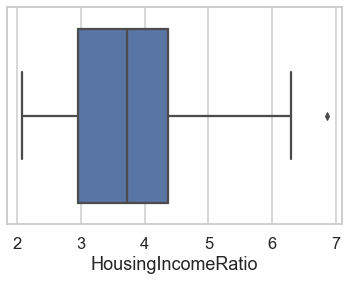

In [20]:
# boxplot of housing price to income ratio
sns.set_context("talk")
sns.boxplot(metros.HousingIncomeRatio)
print("Mean Housing Income Ratio: {}".format(metros.HousingIncomeRatio.mean()))
print("Median Housing Income Ratio: {}".format(metros.HousingIncomeRatio.median()))

Based on a mix of industry research and the above data exploration, we will establish a cut-off of 3.7, which is essentially at the median level for the given metros in the PNW.

In [21]:
# retain metro areas with good housing price to income ratios below 3.7
metros_final = metros[metros.HousingIncomeRatio <= 3.7]
metros_final.shape

(19, 273)

## 3rd Level Subset - Select top 10 zip codes with highest growth over last 10 years

Now we have 19 metros in our final metro selection. We will now look at the zip codes in those 19 metros to select the top 10 zip codes with consistent growth since 2008.

In [22]:
# make a list of final metros to iterate through
metros_final_list = list(metros_final.index).copy()

In [23]:
# subset original pnw df based on final metros
select_metros = pnw_subset[pnw_subset['Metro'].isin(metros_final_list)].copy()

In [24]:
select_metros.Metro.value_counts()

Spokane                34
Salem                  21
Roseburg               14
Yakima                 14
Olympia                11
Aberdeen               10
Albany                  8
Kennewick               8
Wenatchee               7
Coos Bay                6
Centralia               6
Longview                6
Hermiston-Pendleton     6
Klamath Falls           5
Moses Lake              5
Walla Walla             4
Ontario                 3
La Grande               2
The Dalles              1
Name: Metro, dtype: int64

In [25]:
# Calculate growth over past 10 years and select top 10 zip codes with highest growth
select_metros['Growth_20082018'] = (select_metros['2018-04'] - select_metros['2008-04']) / select_metros['2008-04']
top10_zip = select_metros.nlargest(10, 'Growth_20082018')

## 4th Level Subset - Select 5 Zip Codes with lowest volatility over last 10 years

From the 10 zip codes with the highest growth, we will now identify the 5 within those that have the lowest risk in order to adapt to Redwood's slight risk aversion.

In [26]:
# subset top 10 zips for those with the lowest variability (lowest normalized std)
top10_zip['Risk'] = top10_zip.loc[:,'2008-04':'2018-04'].std(skipna=True, axis=1)/top10_zip.loc[:,'2008-04':'2018-04'].mean(skipna=True,axis=1)

In [27]:
# Rename RegionName to ZipCode and set to str type
top10_zip.rename(columns={'RegionName': 'ZipCode'}, inplace=True)
top10_zip['ZipCode'] = top10_zip['ZipCode'].astype(str)

In [28]:
# Subset to select final 5 zip codes with lowest risk
top5_zip = top10_zip.nsmallest(5, 'Risk').copy()

In [29]:
top5_zip

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth_20082018,Risk
4674,100208,99354,Richland,WA,Kennewick,Benton,4675,112300.0,112700.0,113100.0,...,228200,230200,232400,233600,234600,235500,236500,237100,0.439587,0.115990
2056,100206,99352,Richland,WA,Kennewick,Benton,2057,NaN,NaN,NaN,...,286800,288800,290800,291700,292700,292800,292500,292500,0.447303,0.125856
643,100194,99336,Kennewick,WA,Kennewick,Benton,644,90500.0,90600.0,90700.0,...,195800,196900,198900,200400,201500,202600,204100,204900,0.469871,0.129042
10317,99216,97352,Jefferson,OR,Salem,Marion,10318,84300.0,84600.0,84900.0,...,211000,213300,215800,218300,221000,223500,226500,228600,0.420758,0.140263
180,100179,99301,Pasco,WA,Kennewick,Franklin,181,92400.0,91900.0,91400.0,...,210100,212600,214200,216000,217600,218300,218100,217600,0.668712,0.142093


# **Step 2: Data Preparation**

## *Guiding Questions:*
"Once we have a strong understanding of our data, we can move onto preparing the data for our modeling steps.

During this stage, we'll want to handle the following issues:
- Detecting and dealing with missing values
- Data type conversions (e.g. numeric data mistakenly encoded as strings)
- Checking for and removing multicollinearity (correlated predictors)
- Normalizing our numeric data
- Converting categorical data to numeric format through one-hot encoding"


## Approach

We will now prep the time series data for modeling. This includes:
- Check for Missing Values
- Melt data to put in Long Format
- Check for trends:
    - visualize
    - rolling statistics
    - Dicky-Fuller test
- Remove trends
    - Use differencing to reduce non-stationarity
    - Time-Series Decomposition if needed
- Check ACF and PACF

## Dealing with Missing Values

In [30]:
top5_zip.isnull()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth_20082018,Risk
4674,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2056,False,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
643,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10317,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
180,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
# look at number of null values per zip code (per row)
top5_zip.isnull().sum(axis=1)

4674      0
2056     87
643       0
10317     0
180       0
dtype: int64

In [32]:
# since only one row has missing data, let's look at which columns (i.e. dates) have null values
top5_zip.columns[top5_zip.isnull().any()]

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01', '1997-02', '1997-03',
       '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09',
       '1997-10', '1997-11', '1997-12', '1998-01', '1998-02', '1998-03',
       '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09',
       '1998-10', '1998-11', '1998-12', '1999-01', '1999-02', '1999-03',
       '1999-04', '1999-05', '1999-06', '1999-07', '1999-08', '1999-09',
       '1999-10', '1999-11', '1999-12', '2000-01', '2000-02', '2000-03',
       '2000-04', '2000-05', '2000-06', '2000-07', '2000-08', '2000-09',
       '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03',
       '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09',
       '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03',
       '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09',
       '2002-10', '2002-11', '2002-12', '2003-01', 

From the above, we can see that one of our zip codes is missing home price data through June 2003, which is almost 8 years of data. Given this, we do not advise filling the null values through back or forward filling, but instead we will proceed with data from 2004-04 onwards for all 5 zip codes.

In [33]:
# Drop all columns before 2004-04
col = list(top5_zip.columns)[7:103]
top5_zip.drop(col, axis=1, inplace=True)
top5_zip.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,2004-04,2004-05,2004-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth_20082018,Risk
4674,100208,99354,Richland,WA,Kennewick,Benton,4675,148600.0,150000.0,151700.0,...,228200,230200,232400,233600,234600,235500,236500,237100,0.439587,0.115990
2056,100206,99352,Richland,WA,Kennewick,Benton,2057,182000.0,182400.0,183300.0,...,286800,288800,290800,291700,292700,292800,292500,292500,0.447303,0.125856
643,100194,99336,Kennewick,WA,Kennewick,Benton,644,125000.0,125600.0,126500.0,...,195800,196900,198900,200400,201500,202600,204100,204900,0.469871,0.129042
10317,99216,97352,Jefferson,OR,Salem,Marion,10318,122100.0,124100.0,126100.0,...,211000,213300,215800,218300,221000,223500,226500,228600,0.420758,0.140263
180,100179,99301,Pasco,WA,Kennewick,Franklin,181,118000.0,116600.0,115300.0,...,210100,212600,214200,216000,217600,218300,218100,217600,0.668712,0.142093


In [34]:
top5_zip.isnull().sum(axis=1)

4674     0
2056     0
643      0
10317    0
180      0
dtype: int64

In [35]:
# Quick look at df of final zip codes
top5_zip

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,2004-04,2004-05,2004-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth_20082018,Risk
4674,100208,99354,Richland,WA,Kennewick,Benton,4675,148600.0,150000.0,151700.0,...,228200,230200,232400,233600,234600,235500,236500,237100,0.439587,0.115990
2056,100206,99352,Richland,WA,Kennewick,Benton,2057,182000.0,182400.0,183300.0,...,286800,288800,290800,291700,292700,292800,292500,292500,0.447303,0.125856
643,100194,99336,Kennewick,WA,Kennewick,Benton,644,125000.0,125600.0,126500.0,...,195800,196900,198900,200400,201500,202600,204100,204900,0.469871,0.129042
10317,99216,97352,Jefferson,OR,Salem,Marion,10318,122100.0,124100.0,126100.0,...,211000,213300,215800,218300,221000,223500,226500,228600,0.420758,0.140263
180,100179,99301,Pasco,WA,Kennewick,Franklin,181,118000.0,116600.0,115300.0,...,210100,212600,214200,216000,217600,218300,218100,217600,0.668712,0.142093


In [36]:
# Drop regionid column
top5_zip.drop('RegionID', inplace=True, axis=1)

In [37]:
# drop SizeRank column
top5_zip.drop('SizeRank', inplace=True, axis=1)

## Reshape from Wide to Long Format

In [38]:
# function to melt data to operate on as time-series data
def melt_data(df):
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName', 'Growth_20082018', 'Risk'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time', inplace=True)
    melted = melted.dropna(subset=['value'])
    return melted
    #return melted.groupby('time').aggregate({'value':'mean'})

In [39]:
# Grab final 5 zip codes
zip_list = list(top5_zip.ZipCode.values)
zip_list

['99354', '99352', '99336', '97352', '99301']

In [40]:
# Create a new data frame for contents from melt_data function
zip_ts = pd.DataFrame()
for z in zip_list:
    d = melt_data(top5_zip[top5_zip.ZipCode==z])
    zip_ts = pd.concat([d, zip_ts])
zip_ts.head()

,ZipCode,City,State,Metro,CountyName,Growth_20082018,Risk,value
time,,,,,,,,
2004-04-01,99301,Pasco,WA,Kennewick,Franklin,0.668712,0.142093,118000.0
2004-05-01,99301,Pasco,WA,Kennewick,Franklin,0.668712,0.142093,116600.0
2004-06-01,99301,Pasco,WA,Kennewick,Franklin,0.668712,0.142093,115300.0
2004-07-01,99301,Pasco,WA,Kennewick,Franklin,0.668712,0.142093,113900.0
2004-08-01,99301,Pasco,WA,Kennewick,Franklin,0.668712,0.142093,112100.0


In [41]:
# Confirm date time data type for index
zip_ts.index

DatetimeIndex(['2004-04-01', '2004-05-01', '2004-06-01', '2004-07-01',
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=845, freq=None)

## Check for Trends

In [42]:
zip_ts.isnull().sum()

ZipCode            0
City               0
State              0
Metro              0
CountyName         0
Growth_20082018    0
Risk               0
value              0
dtype: int64

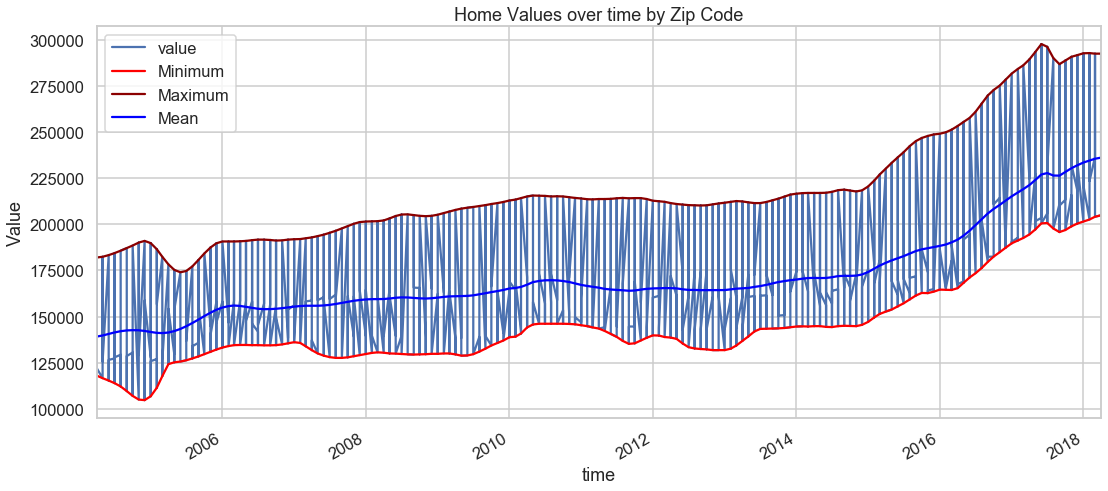

In [43]:
# exploratory visualization of home values over entire timeframe for all 5 zip codes
zip_ts.value.plot(figsize=(18,8))
minimum = zip_ts.groupby('time').aggregate({'value': 'min'})
maximum = zip_ts.groupby('time').aggregate({'value': 'max'})
mean = zip_ts.groupby('time').aggregate({'value': 'mean'})
plt.plot(minimum, color='red', label="Minimum")
plt.plot(maximum, color="darkred", label="Maximum")
plt.plot(mean, color="blue", label="Mean")
plt.legend(loc="best")
plt.title('Home Values over time by Zip Code')
plt.ylabel('Value')
plt.show()

From the above, we can infer that the data is non-stationary, as there appears to be an upward linear trend over time. Let's now take the rolling mean and std as another test for trends in our data.

### Stationarity Check: Rolling Statistics & Dickey-Fuller Test

In [44]:
# Using the top5_zip dataframe, make a list of the titles to use for visualizations
# Start with an empty list
titles = []

# User iterrows to iterate through each row and grab the necessary info
for index, rows in top5_zip.iterrows():
    title = f'City: {rows.City}, Metro: {rows.Metro}, {rows.State}, Zip Code: {rows.ZipCode}'
    # Append to the final list
    titles.append(title)
    
print(titles)

['City: Richland, Metro: Kennewick, WA, Zip Code: 99354', 'City: Richland, Metro: Kennewick, WA, Zip Code: 99352', 'City: Kennewick, Metro: Kennewick, WA, Zip Code: 99336', 'City: Jefferson, Metro: Salem, OR, Zip Code: 97352', 'City: Pasco, Metro: Kennewick, WA, Zip Code: 99301']


In [45]:
# Create a dict of zip codes with the chart titles for easy retrieval
titles_dict = dict(zip(zip_list, titles))
titles_dict

{'99354': 'City: Richland, Metro: Kennewick, WA, Zip Code: 99354',
 '99352': 'City: Richland, Metro: Kennewick, WA, Zip Code: 99352',
 '99336': 'City: Kennewick, Metro: Kennewick, WA, Zip Code: 99336',
 '97352': 'City: Jefferson, Metro: Salem, OR, Zip Code: 97352',
 '99301': 'City: Pasco, Metro: Kennewick, WA, Zip Code: 99301'}

We will now conduct a stationarity check by examining the rolling statistics for each zip code and conducting the Augmented Dickey-Fuller test (adf) to verify the visual results. The ADF test is a statistical test for testing stationarity, with a null hypothesis that the time series is **not** stationary. This means if the test statistic is less than the critical value, we reject the null hypothesis and conclude that the time series is stationary.

In [46]:
# define function to calculate and plot rolling statistics, then conduct the adf test with output printed
def stationarity_check(ts, wd=8):
    # ts = time series in pd.Series (not in pd.DataFrame)
    rolmean = ts.rolling(window=wd, center=False).mean()
    rolstd = ts.rolling(window=wd, center=False).std()
    fig = plt.figure(figsize=(16,5))
    orig = plt.plot(ts, label="Original")
    mean = plt.plot(rolmean, label="Rolling Mean")
    std = plt.plot(rolstd, label="Rolling Std")
    plt.style.use('seaborn-dark-palette')
    plt.legend(loc="best")
    plt.title("Rolling Mean & Std")
    plt.show(block=False)
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 
                                              'p-value', 
                                              '#Lags Used', 
                                              'Number of Observations'])
    for key, value in dftest[4].items():
        dfoutput['CriticalValue(%s)'%key] = value
    return(dfoutput)

Stationarity check for City: Richland, Metro: Kennewick, WA, Zip Code: 99354 



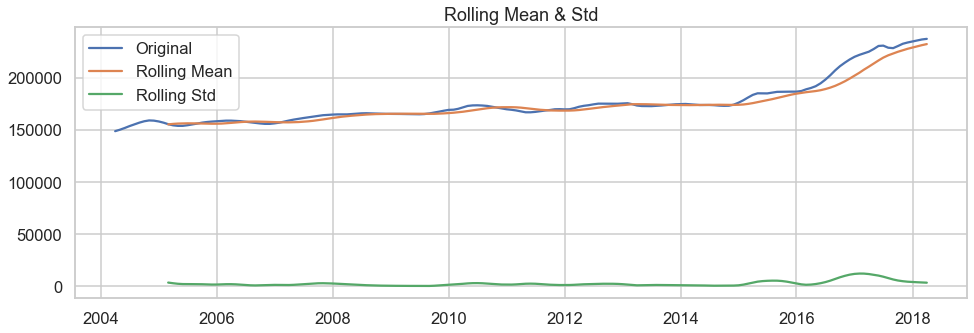

Test Statistic              0.562610
p-value                     0.986657
#Lags Used                 13.000000
Number of Observations    155.000000
CriticalValue(1%)          -3.473259
CriticalValue(5%)          -2.880374
CriticalValue(10%)         -2.576812
dtype: float64


Stationarity check for City: Richland, Metro: Kennewick, WA, Zip Code: 99352 



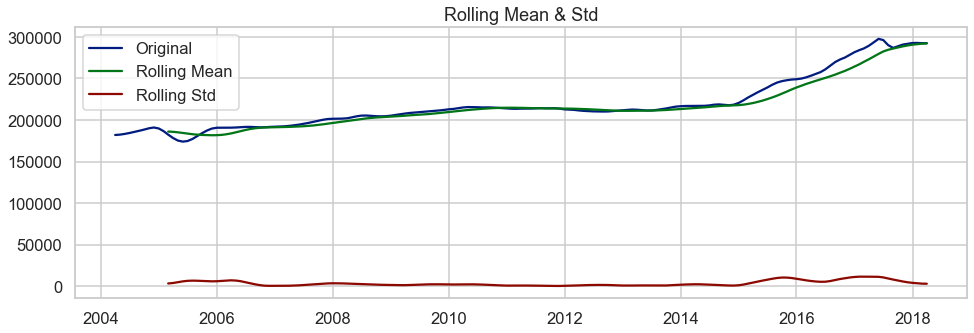

Test Statistic              0.031720
p-value                     0.961078
#Lags Used                 11.000000
Number of Observations    157.000000
CriticalValue(1%)          -3.472703
CriticalValue(5%)          -2.880132
CriticalValue(10%)         -2.576683
dtype: float64


Stationarity check for City: Kennewick, Metro: Kennewick, WA, Zip Code: 99336 



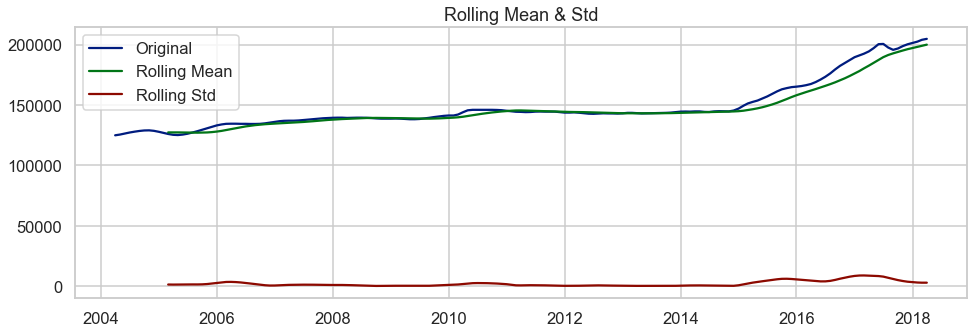

Test Statistic              0.731897
p-value                     0.990453
#Lags Used                 11.000000
Number of Observations    157.000000
CriticalValue(1%)          -3.472703
CriticalValue(5%)          -2.880132
CriticalValue(10%)         -2.576683
dtype: float64


Stationarity check for City: Jefferson, Metro: Salem, OR, Zip Code: 97352 



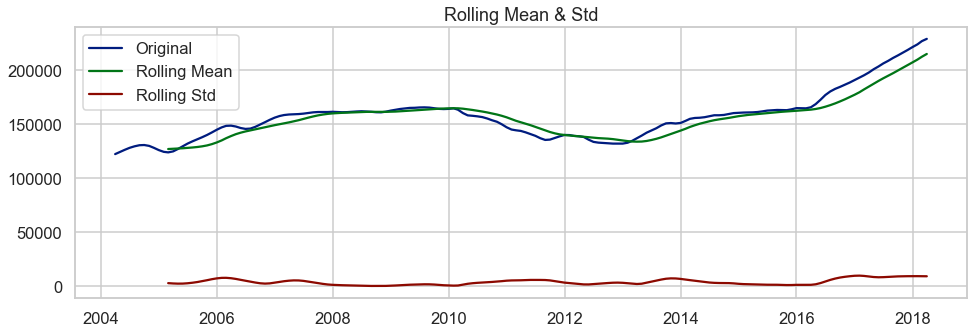

Test Statistic             -0.467995
p-value                     0.898112
#Lags Used                  9.000000
Number of Observations    159.000000
CriticalValue(1%)          -3.472161
CriticalValue(5%)          -2.879895
CriticalValue(10%)         -2.576557
dtype: float64


Stationarity check for City: Pasco, Metro: Kennewick, WA, Zip Code: 99301 



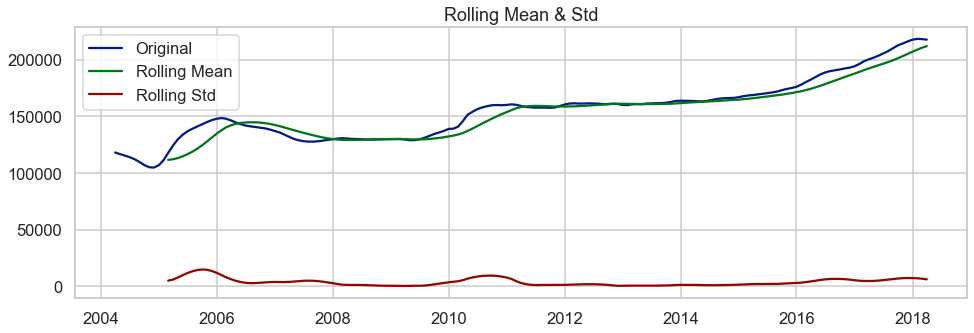

Test Statistic              0.709657
p-value                     0.990029
#Lags Used                 10.000000
Number of Observations    158.000000
CriticalValue(1%)          -3.472431
CriticalValue(5%)          -2.880013
CriticalValue(10%)         -2.576619
dtype: float64




In [47]:
# we will work through each zip code to produce individual stationarity checks
for i, value in enumerate(zip_list):
    ts = zip_ts[zip_ts.ZipCode == value]['value']
    ts = pd.Series(ts)
    
    print("Stationarity check for {} \n".format(titles_dict.get(value)))
    out1 = stationarity_check(ts, wd=12)
    print(out1)
    print('\n')

**Observations on the above stationarity checks:**
Each of the zip codes show rolling means with upward trends and rolling std that are relatively stationary. The ADF results all show high p-values, meaning that we fail to reject the null hypothesis and all are non-stationary.

We will now work on removing the trends before proceeding with modeling and forecasting.

## Remove Trends: Differencing & ACF/PACF

We will now use differencing along with computing the Autocorrelation (ACF) and Partial Autocorrelation Function (PACF) for each of the 5 zip codes. 

Differencing is a common method of dealing with both trend and seasonality, where we take the difference of an observation at a particular time instant with that at the previous instant (this is a 1-period "lag").

In contrast with the ACF, which does not control for other lags, the PACF is a summary of the relationship between a time series element with observations at a lag, with the relationships of intervening observations removed. The PACF can be interpreted as a regression of the series against its past lags

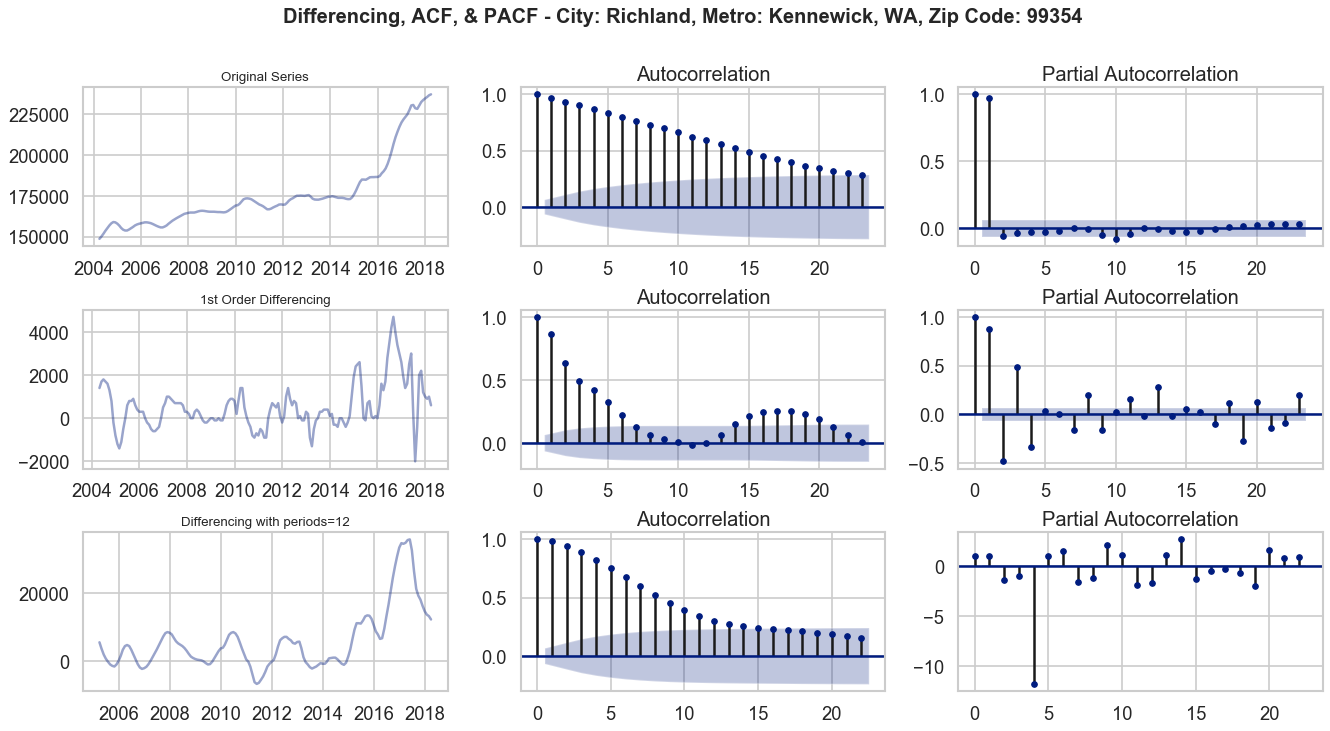

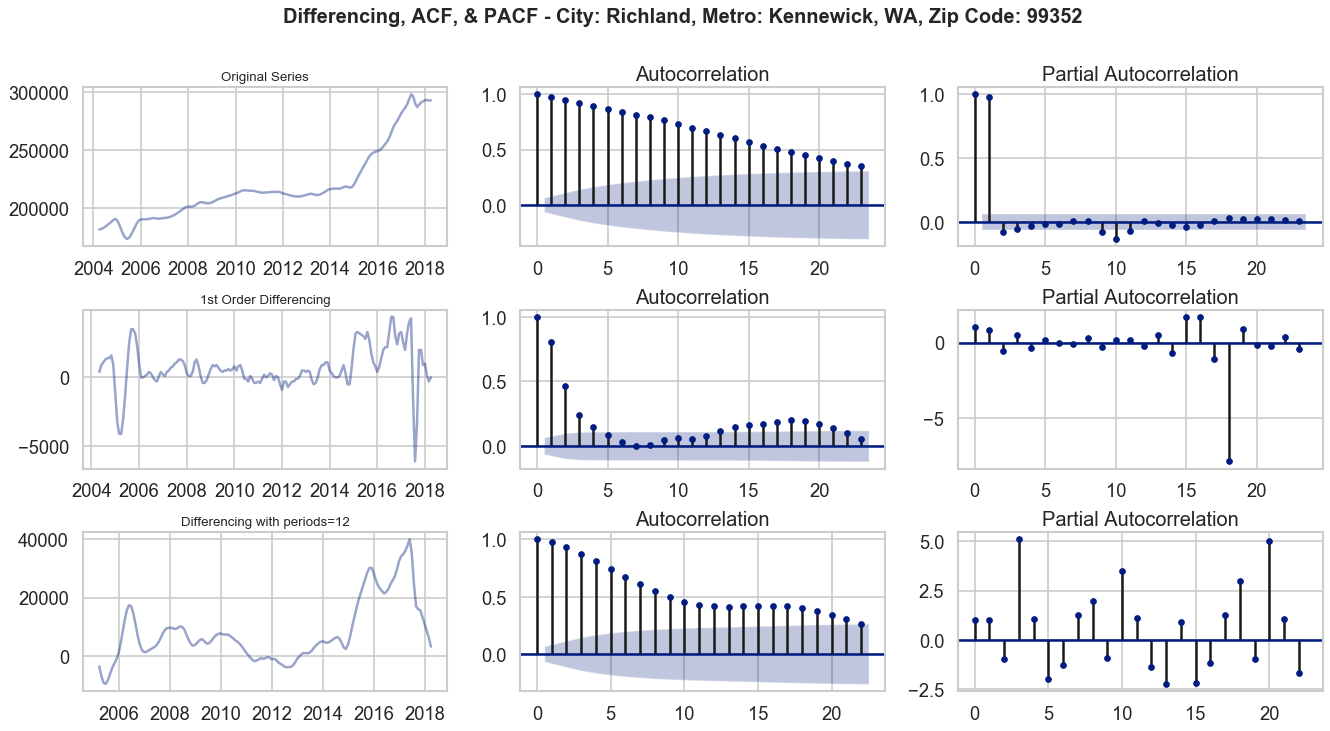

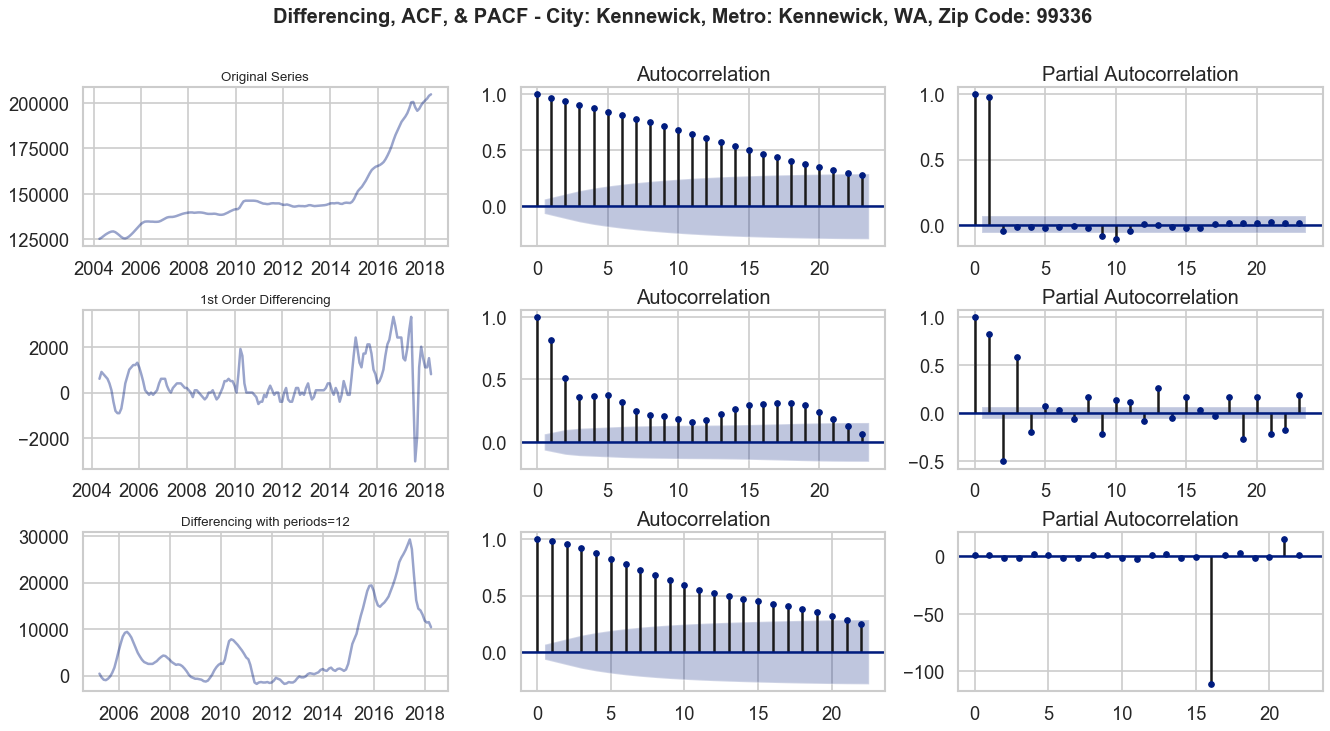

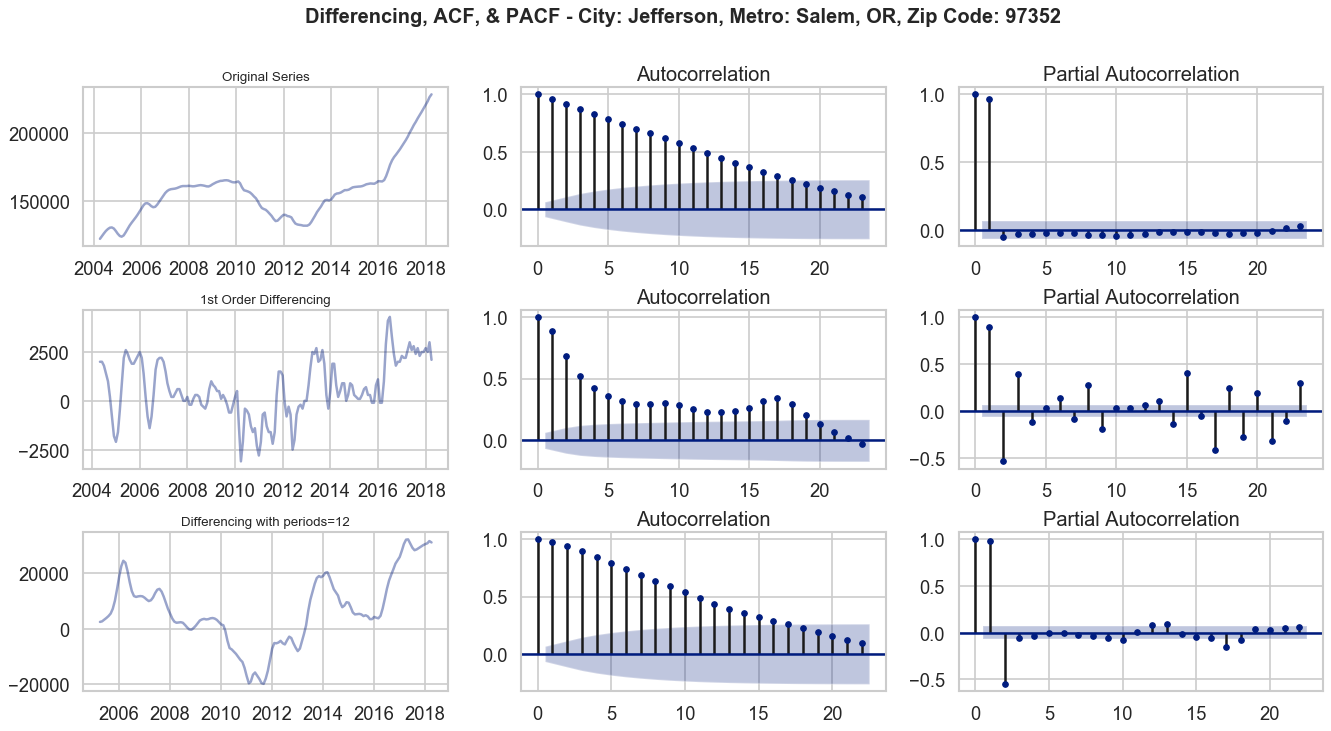

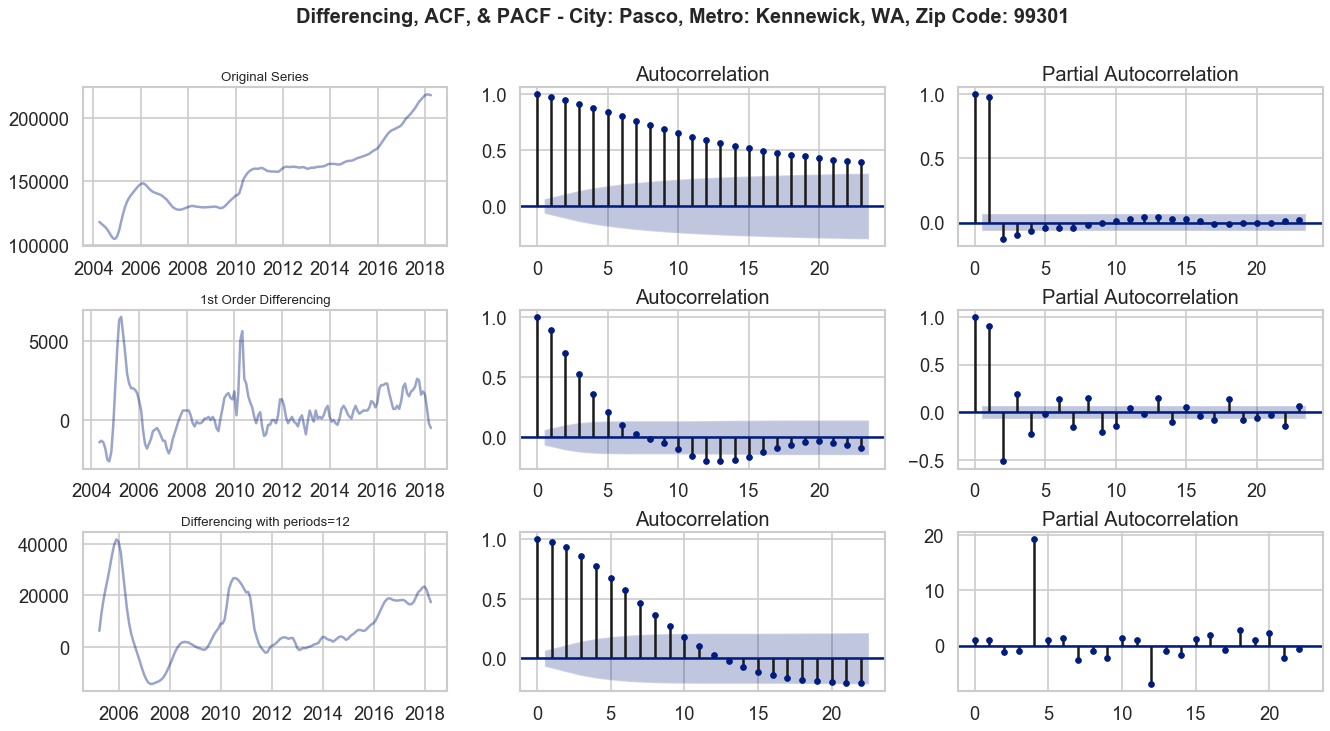

In [48]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':80})
for z in zip_list:
    df_z = zip_ts[zip_ts.ZipCode==z]
    
    #Original Series
    fig, axes = plt.subplots(3, 3)
    axes[0,0].plot(df_z.value, alpha=0.4); axes[0,0].set_title('Original Series', fontsize=12)
    plot_acf(df_z.value, ax=axes[0,1], alpha=0.4)
    plot_pacf(df_z.value, ax=axes[0,2], alpha=0.4)
    
    # 1-lag Differencing
    axes[1,0].plot(df_z.value.diff(), alpha=0.4); axes[1,0].set_title('1st Order Differencing', fontsize=12)
    plot_acf(df_z.value.diff().dropna(), ax=axes[1,1], alpha=0.4)
    plot_pacf(df_z.value.diff().dropna(), ax=axes[1,2], alpha=0.4)
    
    # Differencing with period=12
    axes[2,0].plot(df_z.value.diff(periods=12), alpha=0.4); axes[2,0].set_title('Differencing with periods=12', fontsize=12)
    plot_acf(df_z.value.diff(periods=12).dropna(), ax=axes[2,1], alpha=0.4)
    plot_pacf(df_z.value.diff(periods=12).dropna(), ax=axes[2,2], alpha=0.4)
    
    fig.suptitle('Differencing, ACF, & PACF - {}'.format(titles_dict.get(z)), fontsize=18, fontweight='bold')
    plt.subplots_adjust(hspace=0.4)
    plt.show()

**Interpretation of the above Differencing, ACF & PACF plots:**

Unsurprisingly, each of the differenced models are similar, and the ACF plots for the original (non-differenced) data show high levels of statistically significant correlations through 15 lags, if not 20 lags. Similarly, the PACF for the original data shows a high correlation coefficient for the 1 lag, as expected, with low, non-statistically significant correlation coefficients for the rest of the lags, as expected. However, for 1st Order Differencing (with a periods = 1 lag) we see a steeper decline in the correlations under the ACFs, as well as an overall de-trending in the upward trend of the data. Differencing with periods = 12 does not produce as sharp of a decline in the ACF correlation coefficients and the PACFs tend to jump around between negative and positive correlation coefficients. 

We will now move onto testing out modeling approaches starting with one zip code before building out a fuller model for deployment with all 5 zip codes.

# **Step 3: Modeling**

## *Guiding Questions:*

"Once we have clean data, we can begin modeling! Remember, modeling, as with any of these other steps, is an iterative process. During this stage, we'll try to build and tune models to get the highest performance possible on our task.

Consider the following questions during the modeling step:
- Is this a classification task? A regression task? Something else?
- What models will we try?
- How do we deal with overfitting?
- Do we need to use regularization or not?
- What sort of validation strategy will we be using to check that our model works well on unseen data?
- What loss functions will we use?
- What threshold of performance do we consider as successful?"

## Seasonal ARIMA Modeling using SARIMAX

Given that our time series are non-stationary with some significant dependence among values, as indicated by the ACF and PACF plots, we can use an ARIMA model. The ARIMA forecasting is essentially a linear equation, where the predictors depend on the parameters (p, d, q) of the ARIMA model. Below is definition of each of these parameters:

- **Number of AR (Auto-Regressive) terms (p):**

    - p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
    
- **Number of Differences (d):**
    - d is the Integrated component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last n days is small.
    
- **Number of MA (Moving Average) terms (q):**
    - q is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
    
These three parameters account for seasonality, trend, and noise in a time series dataset. For Seasonal ARIMA, the same parameters exist for the Seasonality component (P, D, Q) and S, which accounts for the periodicity of the data.

## SARIMA Model using grid search for parameters

The following is a an attempt to use SARIMAX with grid search for identifying the optimal set of parameters. We will conduct this on one zip code - 99336.

In [49]:
# Grid Search to iteratively explore different combinations of parameters
# Define the p,d,q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Use itertools to generate all combinations of p,d,q
pdq = list(itertools.product(p, d, q))

# Generate all combinations for seasonal P,D,Q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print("Examples of parameter combinations for Seasonal ARIMA...")
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [50]:
# Extract ts for Zip Code 99336 as a test case
ts_99336 = zip_ts[zip_ts.ZipCode=='99336']['value']

In [51]:
# Use AIC for comparing model fit - looking for the model with the lowest AIC

# using SARIMAX to fit the Seasonal ARIMA model with print out of AIC
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_99336, order=param, 
                                           seasonal_order=param_seasonal, 
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 = AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 = AIC: 4482.952852177971
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 = AIC: 4066.002321825386
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 = AIC: 3301.5388611831104
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 = AIC: 3057.8203245672157
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 = AIC: 3242.93307945695
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 = AIC: 3225.0127165656586
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 = AIC: 2960.7666960537313
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 = AIC: 3781.732428057428
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 = AIC: 4337.36663523505
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 = AIC: 4000.237850656611
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 = AIC: 3285.6240362122744
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 = AIC: 4298.739818344955
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 = AIC: 4037.6193756195453
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 = AIC: 3988.1644376100094
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 = AIC: 2945.204101950926
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 = AIC: 3610.9852122003394
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 = AIC: 2789.3753450685017
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 = AIC: 257

From above, we can see that `ARIMA(1, 1, 1)x(1, 1, 1, 12)` has the lowest `AIC` of 2177.25. From this grid search, we can consider this to be our optimal parameters and model.

**Fitting the ARIMA Time Series Model** - now that we have the optimal parameters, as can use this as our final model and analyze the results in more depth.

In [52]:
mod = sm.tsa.statespace.SARIMAX(ts_99336, order=(1, 1, 1),
                               seasonal_order=(1, 1, 1, 12), 
                               enforce_stationarity=False, 
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6589      0.041     16.129      0.000       0.579       0.739
ma.L1          0.6805      0.065     10.394      0.000       0.552       0.809
ar.S.L12       0.0384      0.025      1.556      0.120      -0.010       0.087
ma.S.L12      -0.4503      0.062     -7.238      0.000      -0.572      -0.328
sigma2      2.485e+05   2.01e+04     12.356      0.000    2.09e+05    2.88e+05


From the above summary table, we can see that the most important coefficient are the first two - ar.L1 and ma.L1 - while ar.S.L12 is actually statistically insignificant. This likely indicates that our Seasonal AutoRegressive coefficient does not add much predictive power to our model.

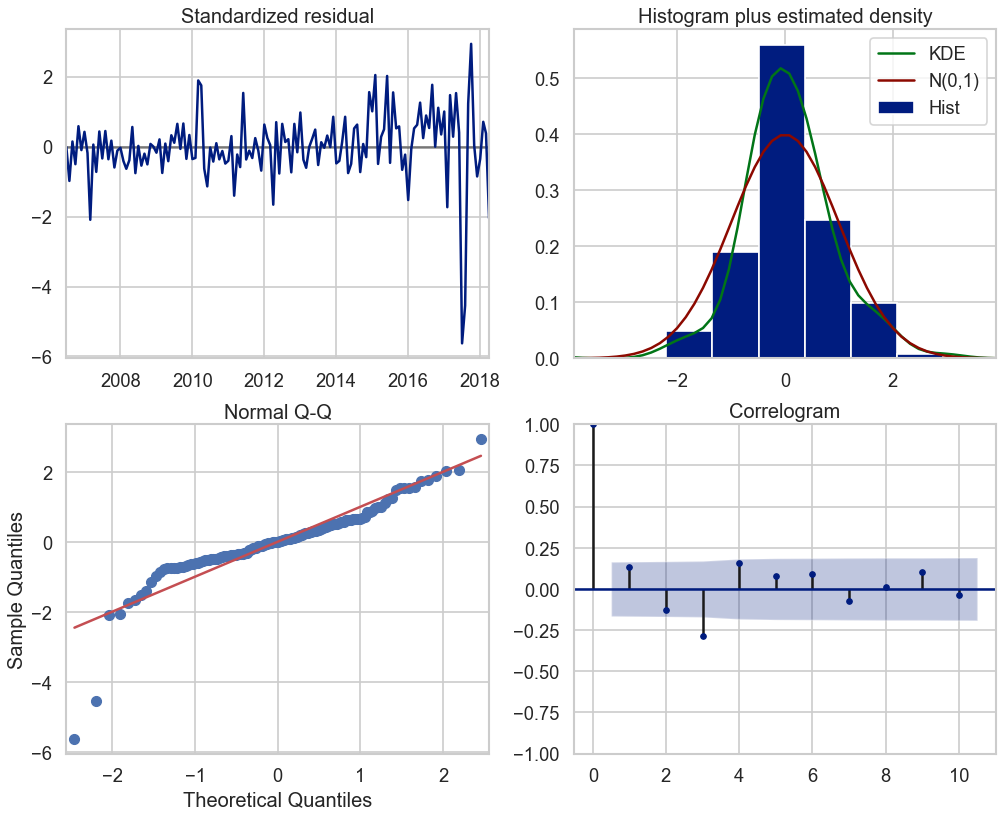

In [53]:
# Examine the model diagnostics
results.plot_diagnostics(figsize=(15,12))
plt.show()

We can see that our residuals don't display any obvious seasonality, confirmed by the correlogram which shows that the time series residuals have low correlation with lagged versions of itself. Ideally, our KDE would follow the normal distribution more closely, and our qq-plot also confirms that our residuals are close to normal, but ideally could use some improvement.

In [54]:
# obtain values and associated confidence intervals for forecasts
pred = results.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_ci = pred.conf_int()

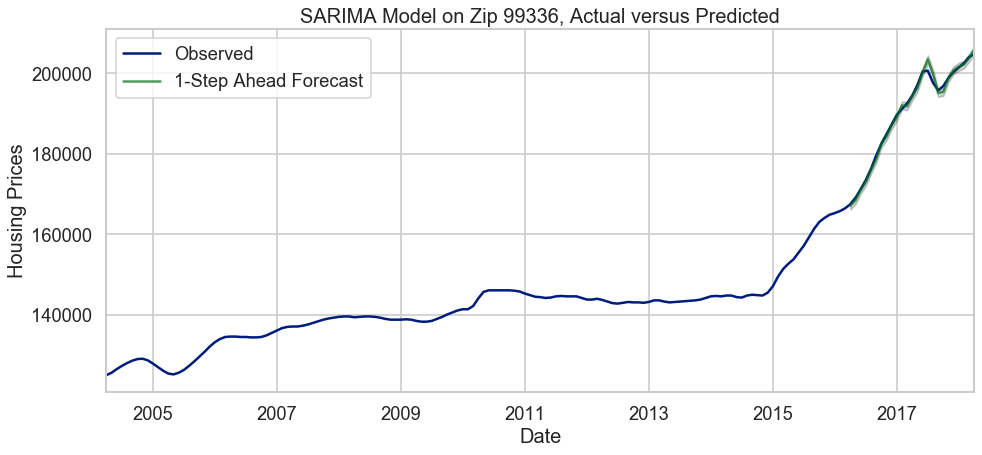

In [55]:
# Using one-step ahead forecasts (dynamic=False), plot observed and forecasted values
ax = ts_99336['2004-04-01':].plot(label="Observed", figsize=(14,6))
pred.predicted_mean.plot(ax=ax, label="1-Step Ahead Forecast", alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:, 1], color="k", alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Housing Prices')
plt.title('SARIMA Model on Zip 99336, Actual versus Predicted')
plt.legend()
plt.show()

In [56]:
# Calculate MSE to summarize the average error of our forecasts
ts_99336_forecasted = pred.predicted_mean
ts_99336_truth = ts_99336['2004-04-01':]

# Compute MSE
mse = ((ts_99336_forecasted - ts_99336_truth)**2).mean()
print("MSE of this forecast is {}".format(round(mse, 2)))

MSE of this forecast is 838988.96


We can now use our SARIMA model to forecast future values using the `get_forecast()` attribute.

In [57]:
# 24 steps for forecasting 2 years into the future
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()

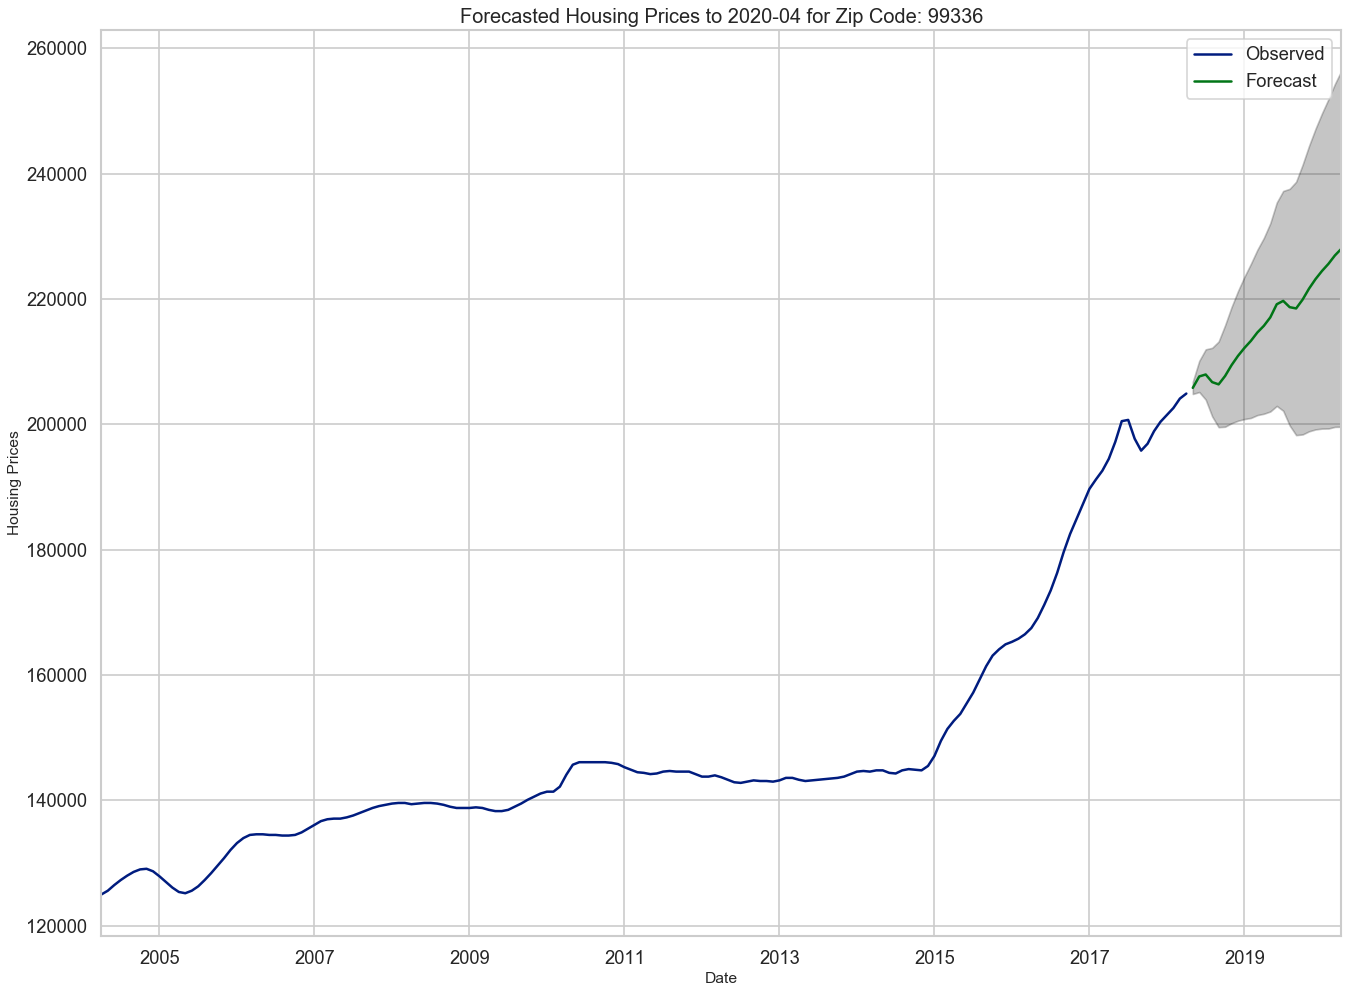

In [58]:
# Plot observed and forecasted values of time series
ax = ts_99336.plot(label="Observed", figsize=(20,15))
pred_uc.predicted_mean.plot(ax=ax, label="Forecast")
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="k", alpha=.25)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Housing Prices', fontsize=14)
plt.title("Forecasted Housing Prices to 2020-04 for Zip Code: 99336")
plt.legend()
plt.show()

The forecast above shows that housing prices are expected to continue increasing into the future. Naturally, the further we go into the future, the more our confidence interval grows larger.

Since the SARIMAX model summary above showed one parameter that added no statistically significant value to the predictive power of our model, we should explore how to improve the parameter tuning. As part of the Evaluation phase, we will use another method for producing ARIMA models, which will allow us to test a larger range of parameter values.

# **Step 4: Evaluating**

"During this step, we'll evaluate the results of our modeling efforts. Does our model solve the problems that we outlined all the way back during step 1? Why or why not? Often times, evaluating the results of our modeling step will raise new questions, or will cause us to consider changing our approach to the problem. Notice from the CRISP-DM diagram above, that the "Evaluation" step is unique in that it points to both Business Understanding and Deployment. As we mentioned before, Data Science is an iterative process -- that means that given the new information our model has provided, we'll often want to start over with another iteration, armed with our newfound knowledge! Perhaps the results of our model showed us something important that we had originally failed to consider the goal of the project or the scope. Perhaps we learned that the model can't be successful without more data, or different data. Perhaps our evaluation shows us that we should reconsider our approach to cleaning and structuring the data, or how we frame the project as a whole (e.g. realizing we should treat the problem as a classification rather than a regression task). In any of these cases, it is totally encouraged to revisit the earlier steps. Of course, if the results are satisfactory, then we instead move onto deployment!"


## Auto-Arima test

We will implement an ARIMA model from the pyramid-arima library for python, which will allow us to quickly perform a grid search and create a model to fit to the training data.

In [59]:
# Extract ts for Zip Code 99336 as a test case
ts_99336 = zip_ts[zip_ts.ZipCode=='99336']['value']
ts_99336.head()

time
2004-04-01    125000.0
2004-05-01    125600.0
2004-06-01    126500.0
2004-07-01    127300.0
2004-08-01    128000.0
Name: value, dtype: float64

In [60]:
# we can set a range of parameter values and then fit models for all combinations
# AIC will be reported, allowing us to select the model with the optimal parameters
stepwise_model = pm.auto_arima(ts_99336, start_p=1, start_q=1, max_p=3, max_q=3, m=12, 
                            start_P=0, seasonal=True, d=1, D=1, trace=True, 
                             error_action='ignore', suppress_warnings=True, stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2611.977, BIC=2627.226, Fit time=1.169 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2622.543, BIC=2628.643, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2613.338, BIC=2625.537, Fit time=0.444 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2614.011, BIC=2626.211, Fit time=0.410 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2628.143, BIC=2646.442, Fit time=0.963 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2612.108, BIC=2624.308, Fit time=0.430 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2627.765, BIC=2646.064, Fit time=2.671 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2708.677, BIC=2730.026, Fit time=2.833 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2617.461, BIC=2635.760, Fit time=1.062 seconds
Fit ARIMA: order=(1, 1, 0) s

From the above, we can see that the model with the optimal parameters is `ARIMA: order= (1, 1, 1) seasonal_order=(0, 1, 1, 12)`. Now we can move on to fitting this optimal model to our training data.

In [61]:
# set training data up to 2016-04, with testing data (actuals) from 2016-04 through 2018-04
train = ts_99336.loc['2004-04-01':'2016-04-01']
test = ts_99336.loc['2016-05-01':]

In [62]:
# fit the optimal model to our training data
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 1),
      out_of_sample_size=0, scoring='mse', scoring_args=None,
      seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

In [63]:
# Set n_periods to length of test data (2 years, or 24 months)
future_forecast = stepwise_model.predict(n_periods=24)

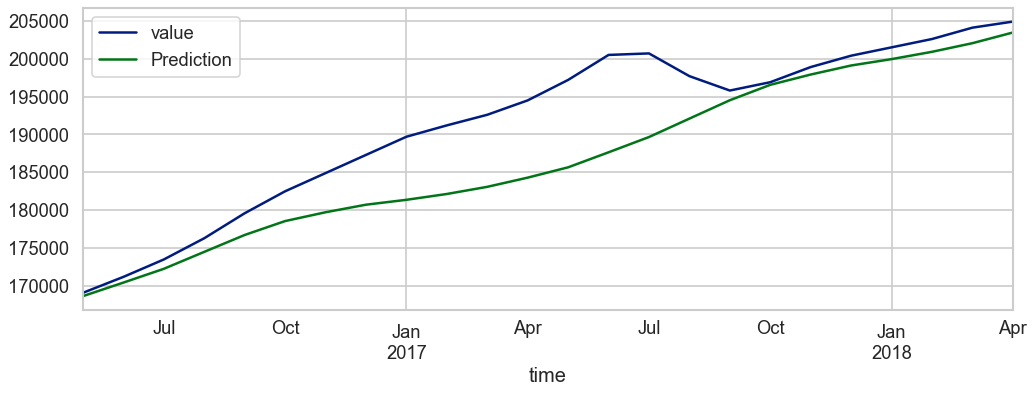

In [64]:
# Create df that contains future forecast and concat with original data
future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Prediction'])

# Plot the prediction versus the actual or observed test data
pd.concat([test, future_forecast], axis=1).plot(figsize=(15,5))

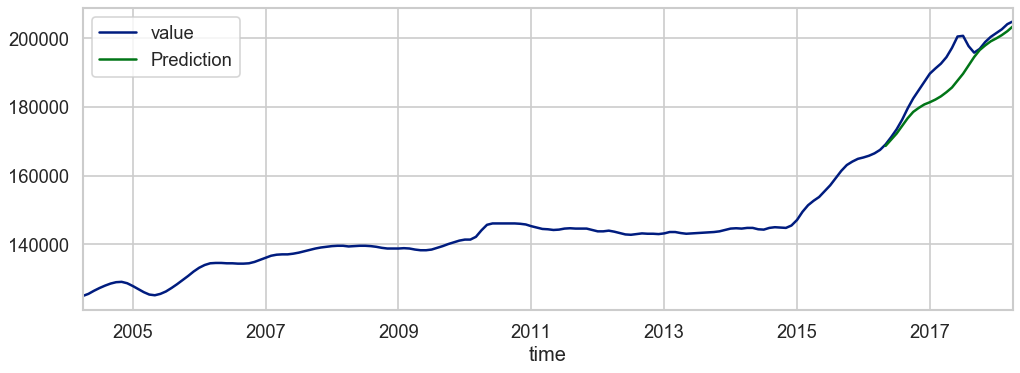

In [65]:
# Compare with entire data set to see context of our predicted values
pd.concat([ts_99336, future_forecast], axis=1).plot(figsize=(15,5))

After modeling and evaluating the SARIMAX model and the pyramid-auto_arima library, we will proceed with building out a comprehensive approach using auto_arima for all 5 zip codes. 

# **Step 5: Deployment**

During this stage, we'll focus on moving our model into production and automating as much as possible. Everything before this serves as a proof-of-concept or an investigation. If the project has proved successful, then you'll work with stakeholders to determine the best way to implement models and insights. For example, you might set up an automated ETL (Extract-Transform-Load) pipelines of raw data in order to feed into a database and reformat it so that it is ready for modeling. During the deployment step, you'll actively work to determine the best course of action for getting the results of your project into the wild, and you'll often be involved with building everything needed to put the software into production.

In this stage, we will take our learnings from the Modeling and Evaluation stages to build out an effective approach for de-trending and controlling for seasonality, applying the auto_arima model, examining the model diagnostics, fitting the model with optimized parameters to training data, and finally forecasting housing prices based on our final model.

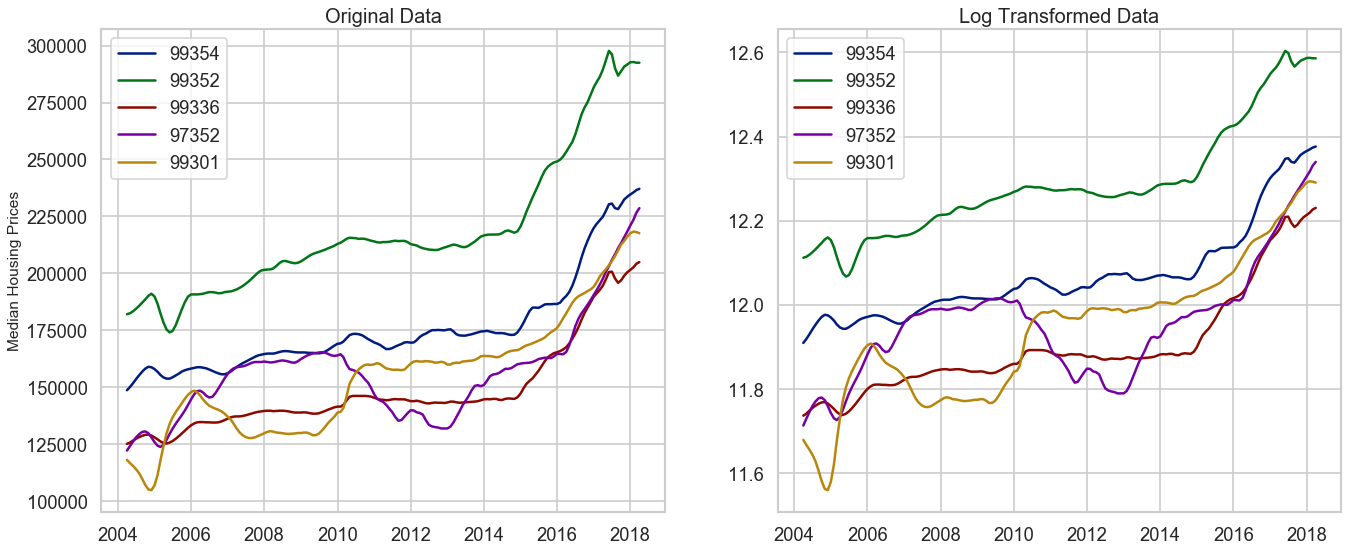

In [66]:
# Quick look at log transformed data versus original
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
for z in zip_list:
    df_z = zip_ts[zip_ts.ZipCode == z]
    axes[0].plot(df_z.value, label=z); axes[0].set_title('Original Data', fontsize=18); axes[0].legend(loc="best"); axes[0].set_ylabel("Median Housing Prices", fontsize=14)
    axes[1].plot(np.log(df_z.value), label=z); axes[1].set_title('Log Transformed Data', fontsize=18); axes[1].legend(loc="best")

Given the above, albeit slight improvement to the trend, we will proceed with time series decomposition using the log transformed data.

In [67]:
# Identify 2018-04 cut off for train test split
for z in zip_list:
    df_z = zip_ts[zip_ts.ZipCode==z]
    print(df_z.value.dropna()[145:])

time
2016-05-01    191700.0
2016-06-01    194500.0
2016-07-01    198000.0
2016-08-01    202200.0
2016-09-01    206900.0
2016-10-01    210900.0
2016-11-01    214300.0
2016-12-01    217300.0
2017-01-01    219900.0
2017-02-01    221800.0
2017-03-01    223200.0
2017-04-01    224800.0
2017-05-01    227300.0
2017-06-01    230300.0
2017-07-01    230600.0
2017-08-01    228600.0
2017-09-01    228200.0
2017-10-01    230200.0
2017-11-01    232400.0
2017-12-01    233600.0
2018-01-01    234600.0
2018-02-01    235500.0
2018-03-01    236500.0
2018-04-01    237100.0
Name: value, dtype: float64
time
2016-05-01    255500.0
2016-06-01    257700.0
2016-07-01    261000.0
2016-08-01    265400.0
2016-09-01    269800.0
2016-10-01    272800.0
2016-11-01    275200.0
2016-12-01    278400.0
2017-01-01    281700.0
2017-02-01    284200.0
2017-03-01    286200.0
2017-04-01    289400.0
2017-05-01    293400.0
2017-06-01    297700.0
2017-07-01    296200.0
2017-08-01    290100.0
2017-09-01    286800.0
2017-10-01    28880

## Option 1 - Model Parameter Settings

We will test two deployments with slightly different parameter settings for the ARIMA model. In this first one, we have adjusted the m (frequency of the series) to 12 to account for 12 months per year, and we are setting the d and D parameters to 1. We will compare the model AIC, MSE, and statistical significance of model summary coefficients between these two different approaches to parameter tuning.


--------------------------------------------------------------------------------

City: Richland, Metro: Kennewick, WA, Zip Code: 99354
Zip: 99354
ADF Statistic Residual: -6.198734
p-value: 0.000000


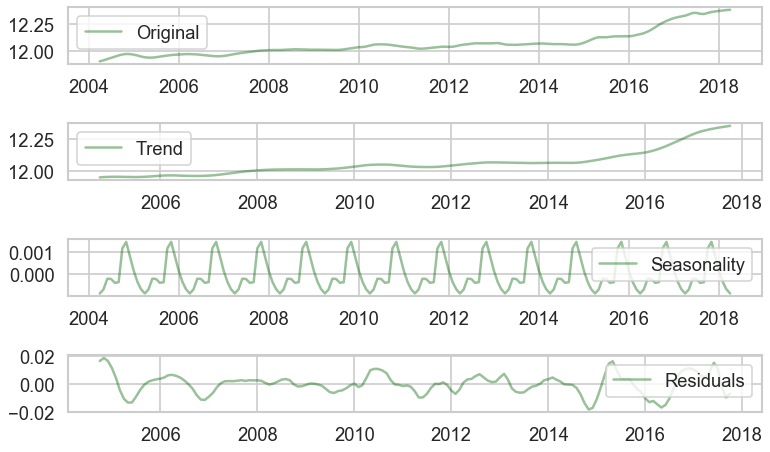

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2700.964, BIC=2716.214, Fit time=0.730 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2722.630, BIC=2728.730, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2708.669, BIC=2720.869, Fit time=0.400 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2709.703, BIC=2721.902, Fit time=0.387 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2703.789, BIC=2722.088, Fit time=0.919 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2702.283, BIC=2714.482, Fit time=0.258 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2715.452, BIC=2733.751, Fit time=2.167 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2724.376, BIC=2745.725, Fit time=2.362 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2701.477, BIC=2719.776, Fit time=0.773 seconds
Fit ARIMA: order=(1, 1, 0) s

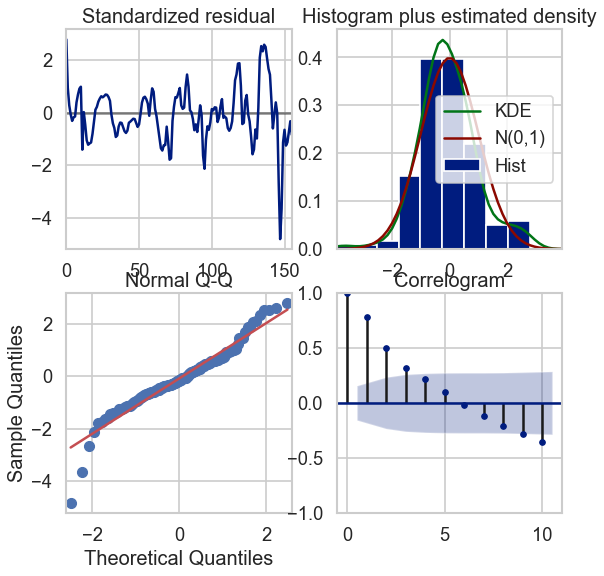

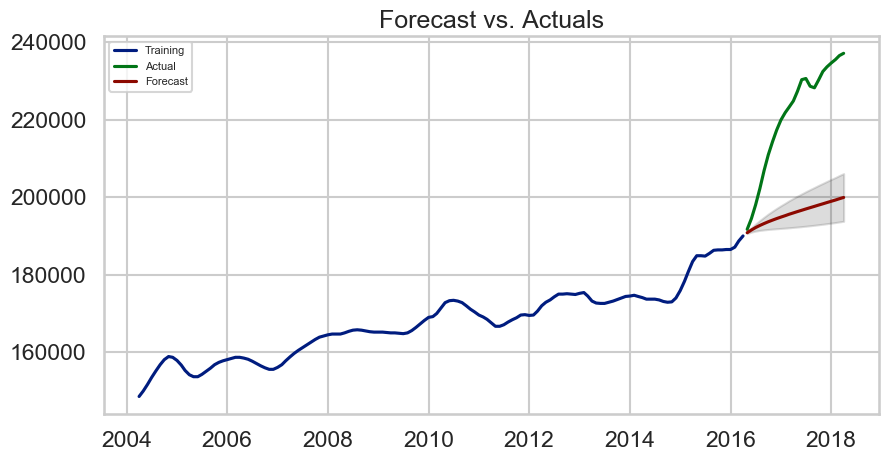

MSE: 765649501.739842


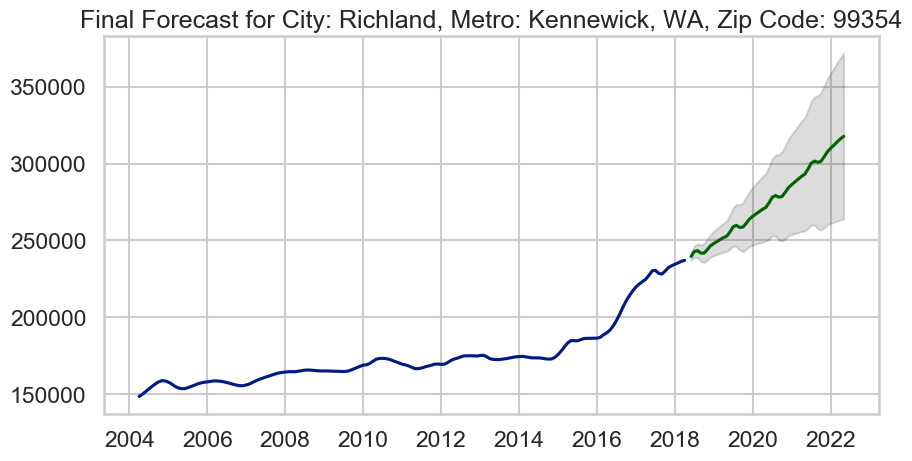

City: Richland, Metro: Kennewick, WA, Zip Code: 99354
Model Order:  (1, 1, 1)
Upside case 2022:  371686.2891072058 ROI:  55.09780801115167
Base Case 2022:  317701.8620701754 ROI:  32.57110593587987
Low case 2022:  263717.435033145 ROI:  10.044403860608075

--------------------------------------------------------------------------------

City: Richland, Metro: Kennewick, WA, Zip Code: 99352
Zip: 99352
ADF Statistic Residual: -5.425640
p-value: 0.000003


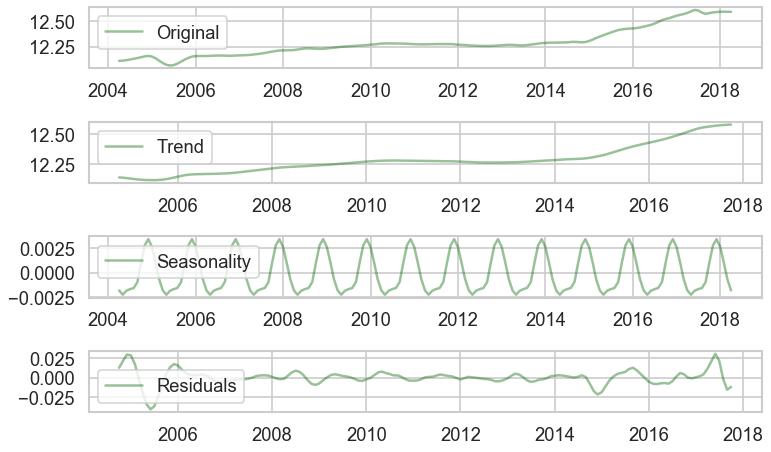

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2774.392, BIC=2789.642, Fit time=1.000 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2795.290, BIC=2801.389, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2776.167, BIC=2788.367, Fit time=0.457 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2808.699, BIC=2820.899, Fit time=0.153 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2845.306, BIC=2863.606, Fit time=1.157 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2799.289, BIC=2811.489, Fit time=0.228 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2818.053, BIC=2836.352, Fit time=2.835 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3002.742, BIC=3024.091, Fit time=2.571 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2809.913, BIC=2828.212, Fit time=0.912 seconds
Fit ARIMA: order=(1, 1, 0) s

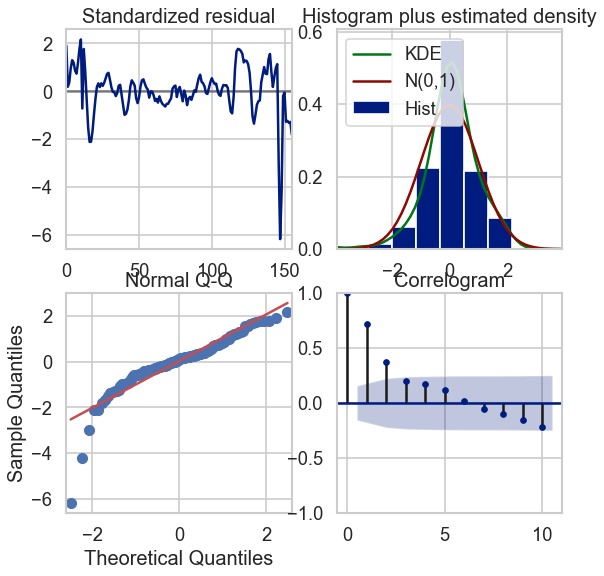

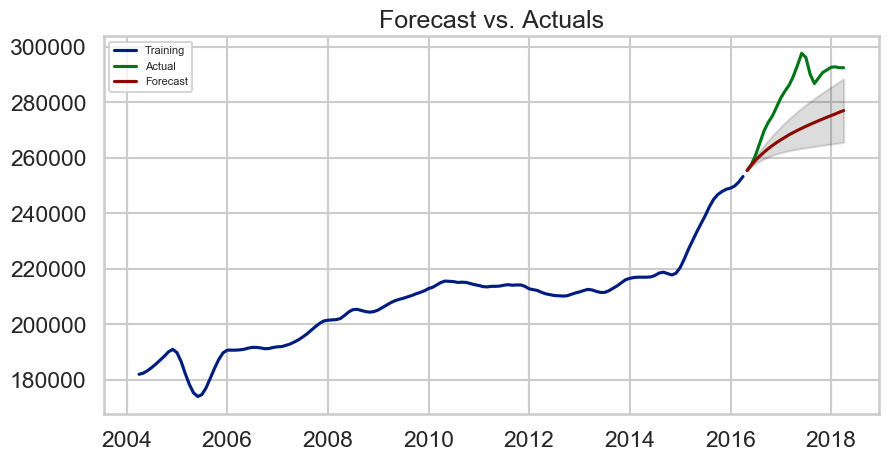

MSE: 250374798.051093


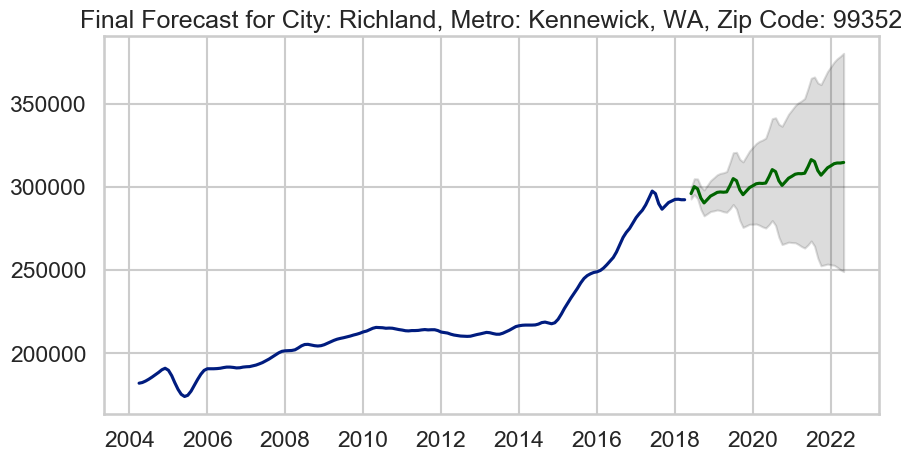

City: Richland, Metro: Kennewick, WA, Zip Code: 99352
Model Order:  (1, 1, 1)
Upside case 2022:  380698.0828783848 ROI:  28.51938910222404
Base Case 2022:  314958.4273366048 ROI:  6.326421104748715
Low case 2022:  249218.7717948248 ROI:  -15.86654689272661

--------------------------------------------------------------------------------

City: Kennewick, Metro: Kennewick, WA, Zip Code: 99336
Zip: 99336
ADF Statistic Residual: -6.302942
p-value: 0.000000


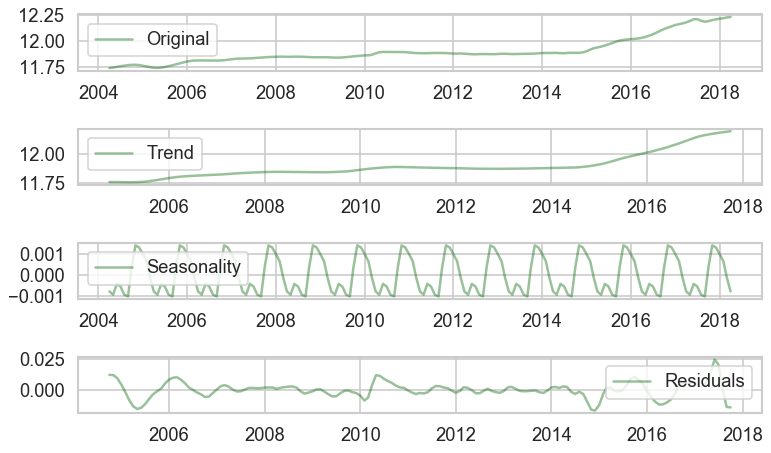

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2611.977, BIC=2627.226, Fit time=0.967 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2622.543, BIC=2628.643, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2613.338, BIC=2625.537, Fit time=0.384 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2614.011, BIC=2626.211, Fit time=0.374 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2628.143, BIC=2646.442, Fit time=0.926 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2612.108, BIC=2624.308, Fit time=0.404 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2627.765, BIC=2646.064, Fit time=2.305 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2708.677, BIC=2730.026, Fit time=2.574 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2617.461, BIC=2635.760, Fit time=1.003 seconds
Fit ARIMA: order=(1, 1, 0) s

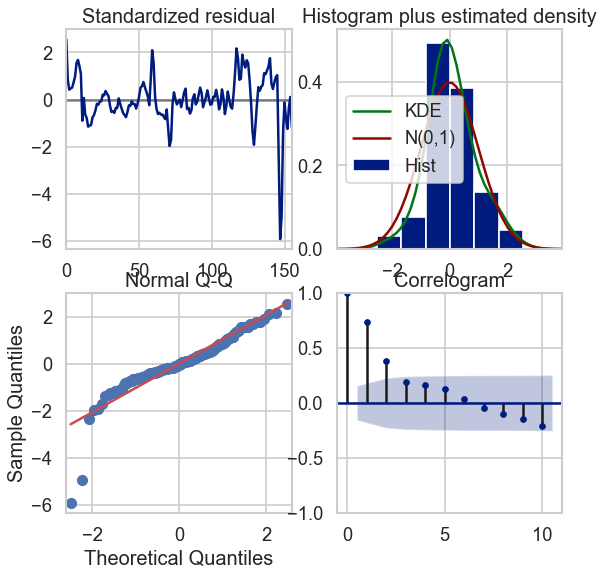

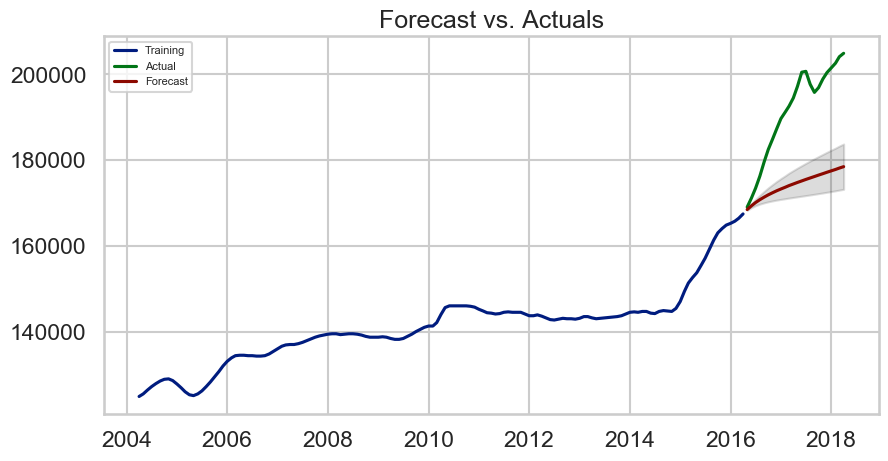

MSE: 355482740.4032189


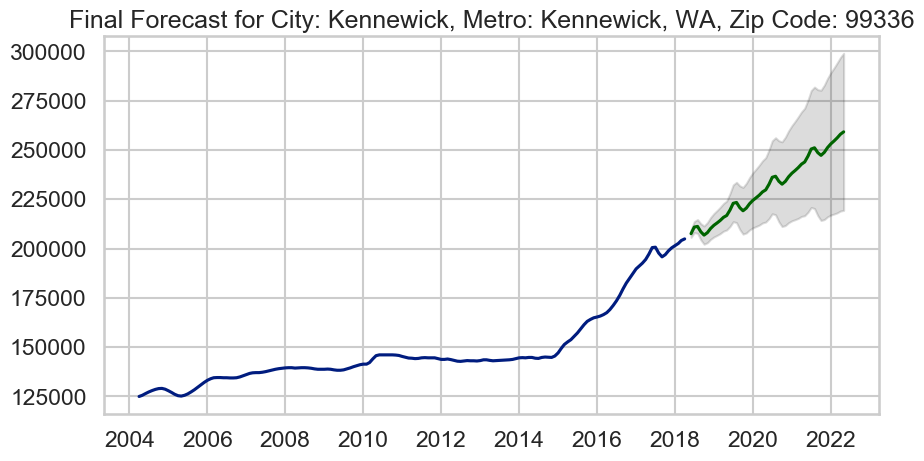

City: Kennewick, Metro: Kennewick, WA, Zip Code: 99336
Model Order:  (1, 1, 1)
Upside case 2022:  299022.3489830734 ROI:  44.05594386647033
Base Case 2022:  259187.74989605646 ROI:  24.865369016335997
Low case 2022:  219353.1508090395 ROI:  5.674794166201651

--------------------------------------------------------------------------------

City: Jefferson, Metro: Salem, OR, Zip Code: 97352
Zip: 97352
ADF Statistic Residual: -5.916325
p-value: 0.000000


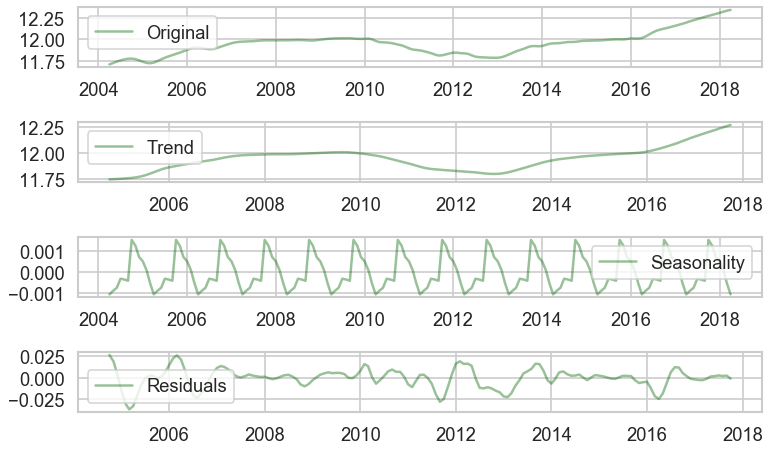

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2766.581, BIC=2781.830, Fit time=0.787 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2771.284, BIC=2777.384, Fit time=0.017 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2766.979, BIC=2779.178, Fit time=0.441 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2767.160, BIC=2779.360, Fit time=0.386 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2780.796, BIC=2799.095, Fit time=1.130 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2764.981, BIC=2777.180, Fit time=0.280 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2788.677, BIC=2797.826, Fit time=0.036 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2766.935, BIC=2782.185, Fit time=0.371 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2765.387, BIC=2774.537, Fit time=0.114 seconds
Fit ARIMA: order=(1, 1, 2) s

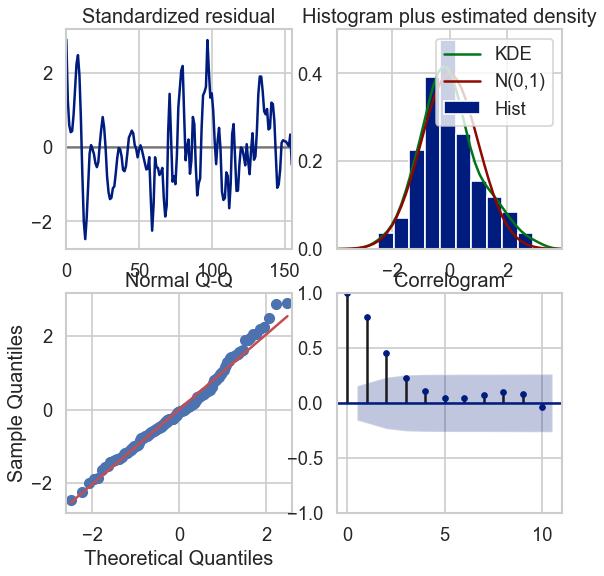

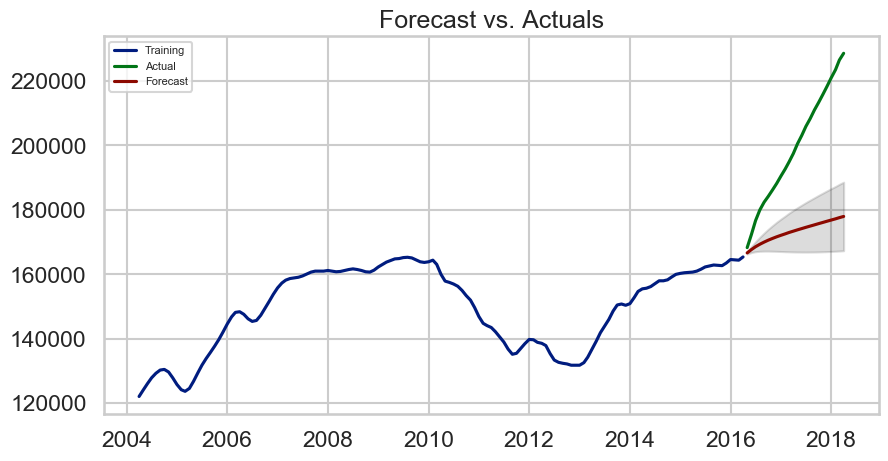

MSE: 897263815.3412541


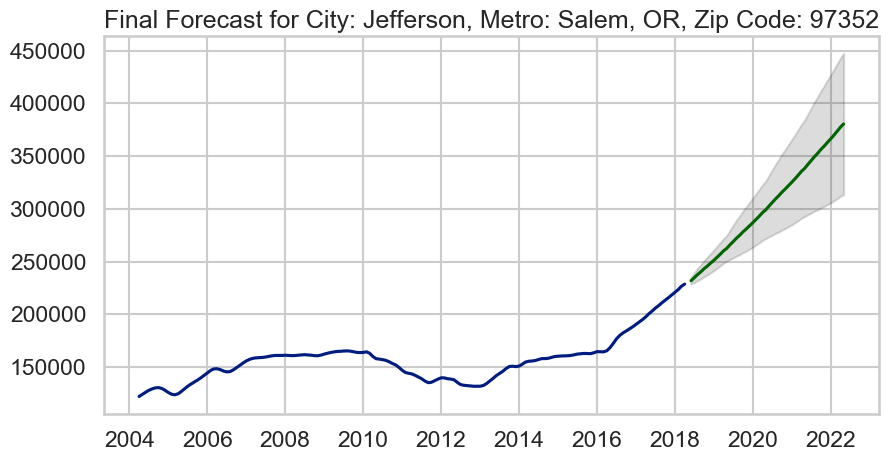

City: Jefferson, Metro: Salem, OR, Zip Code: 97352
Model Order:  (1, 1, 1)
Upside case 2022:  447355.77665428503 ROI:  92.99380260293196
Base Case 2022:  380373.1973049019 ROI:  64.09684100902773
Low case 2022:  313390.61795551877 ROI:  35.1998794151235

--------------------------------------------------------------------------------

City: Pasco, Metro: Kennewick, WA, Zip Code: 99301
Zip: 99301
ADF Statistic Residual: -5.222634
p-value: 0.000008


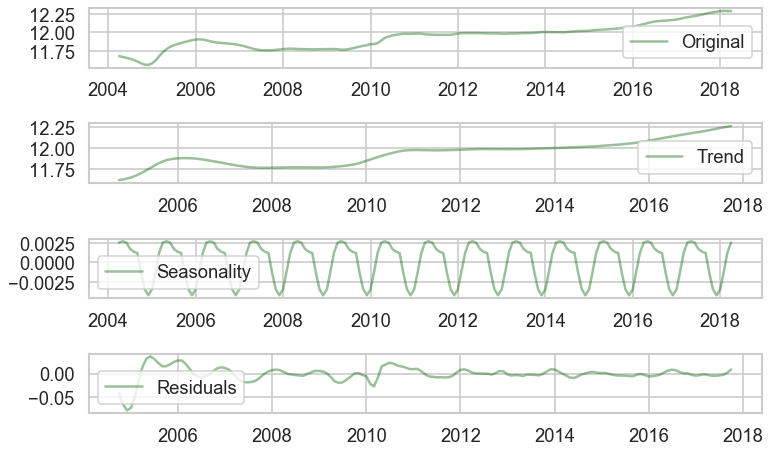

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=3316.233, BIC=3331.515, Fit time=0.874 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=3396.011, BIC=3402.124, Fit time=0.011 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=3255.489, BIC=3267.714, Fit time=0.789 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=3318.262, BIC=3330.487, Fit time=0.132 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=3261.342, BIC=3270.511, Fit time=0.232 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=3256.108, BIC=3271.389, Fit time=2.523 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=3242.816, BIC=3258.097, Fit time=0.669 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=3361.086, BIC=3373.311, Fit time=0.139 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_orde

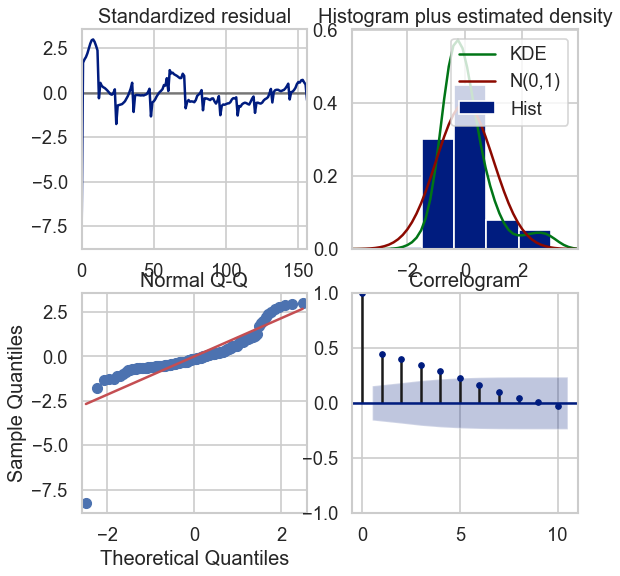

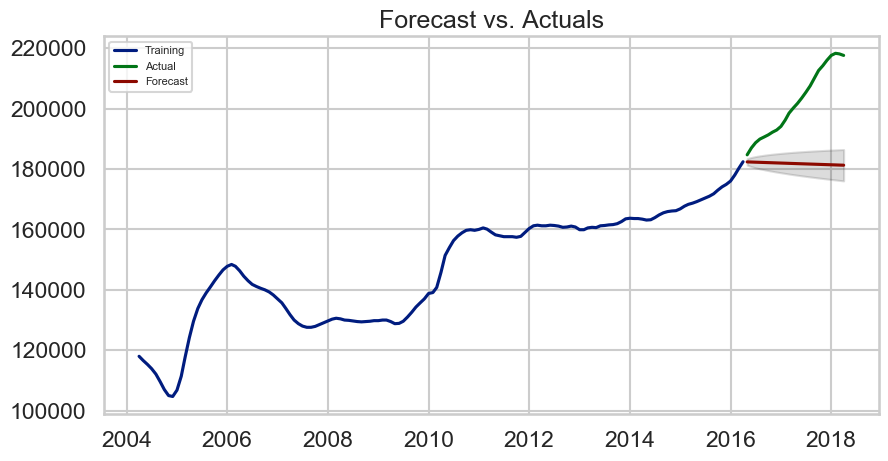

MSE: 540252383.1740297


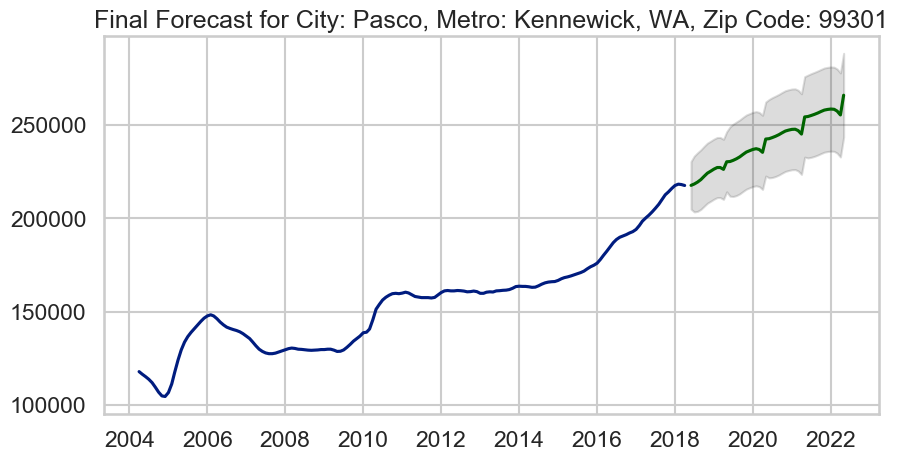

City: Pasco, Metro: Kennewick, WA, Zip Code: 99301
Model Order:  (1, 0, 0)
Upside case 2022:  288319.3804855907 ROI:  32.46631699776375
Base Case 2022:  265883.5709712554 ROI:  22.158341688501064
Low case 2022:  243447.76145692013 ROI:  11.850366379238375


In [71]:
#create an empty list for our residuals
residuals_list = []

for z in zip_list:
    df_z = zip_ts[zip_ts.ZipCode==z]
    ts = df_z.value
    
    decomposition = seasonal_decompose(np.log(ts))
    
    # Isolate the trend, seasonality and residuals of decomposed data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    df_z['res'] = residual
    residuals_list.append(residual)
    
    # Plot the decomposed data objects
    plt.figure(figsize=(10,6))
    plt.subplot(411)
    plt.plot(np.log(ts), label="Original", color="darkgreen", alpha=0.4)
    plt.legend(loc="best")
    plt.subplot(412)
    plt.plot(trend, label="Trend", color="darkgreen", alpha=0.4)
    plt.legend(loc="best")
    plt.subplot(413)
    plt.plot(seasonal, label="Seasonality", color="darkgreen", alpha=0.4)
    plt.legend(loc="best")
    plt.subplot(414)
    plt.plot(residual, label="Residuals", color="darkgreen", alpha=0.4)
    plt.legend(loc="best")
    plt.tight_layout()
    result = adfuller(residual.dropna())
    print('\n--------------------------------------------------------------------------------\n')
    print(titles_dict.get(z))
    print("Zip:", z)
    print("ADF Statistic Residual: %f" % result[0])
    print('p-value: %f' % result[1])
    plt.show()
    
    model = pm.auto_arima(df_z.value.dropna(), start_p=1, start_q=1,
                         test = 'adf',           # Use the ADF test to find the optimal d parameter
                         max_p = 10, max_q = 10, # Set max for p and q
                         m = 12,                 # Set for frequency of the series (months per year)
                         d = None,               # Allowing d to be set by ADF
                         seasonal = True, 
                         start_P = 0, 
                         D = 1,                  #Setting D to 1
                         trace = True, 
                         error_action = 'ignore', 
                         suppress_warnings = True, 
                         stepwise = True)
    print('\n_______________________________________________________________________________\n')
    print(titles_dict.get(z))
    print(model.summary())
    model.plot_diagnostics(figsize=(8, 8))
    plt.show()
    
    #==================== Plot Train and Test =====================
    #df_z.reset_index(inplace=True)
    train = df_z.value.dropna()[:145]    # using 2004 through 2016-04 for training set
    test = df_z.value.dropna()[145:]     # split at 2016-05 onwards for test
    
    test_index = zip_ts.index[-24:]
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit(disp=-1)
    
    # Forecast
    fc, se, conf = fitted.forecast(24, alpha=0.5) # 95% conf level
    
    # Make as Pandas Series
    fc_series = pd.Series(fc, index=test_index)
    lower_series = pd.Series(conf[:, 0], index=test_index)
    upper_series = pd.Series(conf[:, 1], index=test_index)
    
    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label="Training")
    plt.plot(test, label="Actual")
    plt.plot(fc_series, label="Forecast")
    plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=.15)
    plt.title('Forecast vs. Actuals')
    plt.legend(loc="best", fontsize=8)
    plt.show()
    
    print('MSE: {}'.format(np.mean((fc_series - test)**2)))
    
    #===================== Plot Forecast ======================
    #df_z.reset_index(inplace=True)
    n_periods = 48 # to forecast 4 years into the future
    fc, confint = model.predict(n_periods = n_periods, return_conf_int=True)
    #index_of_fc = np.arange(len(df_z.value), len(df_z.value)+n_periods)
    index_of_fc = pd.date_range('2018-05-01', periods=48, freq="M")
    
    # Make into Series for plotting
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))
    
    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(fc_series, color="darkgreen")
    plt.plot(df_z.value)
    plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=.15)
    plt.title("Final Forecast for {}".format(titles_dict.get(z)))
    plt.show()
    print(titles_dict.get(z))
    print("Model Order: ", model.order)
    print('Upside case 2022: ', upper_series[-1], 'ROI: ', (upper_series[-1]-fc_series[-48])/fc_series[-48]*100)
    print("Base Case 2022: ", fc_series[-1], 'ROI: ', (fc_series[-1] - fc_series[-48])/fc_series[-48]*100)
    print("Low case 2022: ", lower_series[-1], 'ROI: ', (lower_series[-1]-fc_series[-48])/fc_series[-48]*100)

## Option 2 - Model Parameter Settings **Final Approach**


--------------------------------------------------------------------------------

City: Richland, Metro: Kennewick, WA, Zip Code: 99354
Zip: 99354
ADF Statistic Residual: -6.198734
p-value: 0.000000


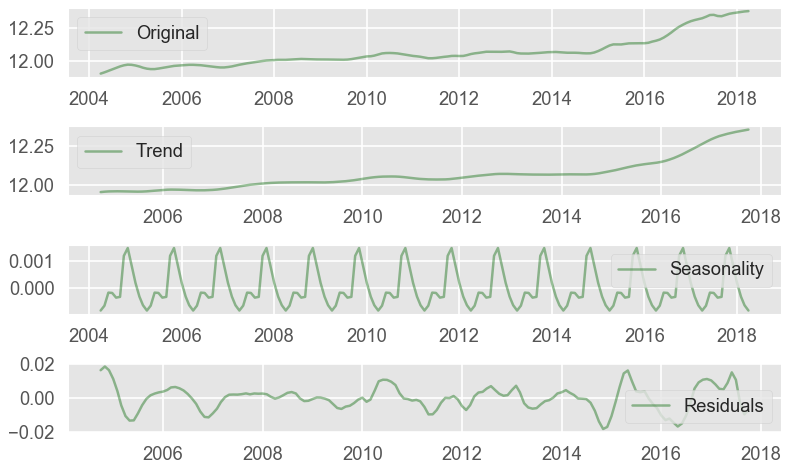

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2803.545, BIC=2816.041, Fit time=0.152 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2822.204, BIC=2828.452, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2825.396, BIC=2834.767, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2817.170, BIC=2826.542, Fit time=0.064 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2804.475, BIC=2820.095, Fit time=0.264 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2803.906, BIC=2819.526, Fit time=0.294 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2844.089, BIC=2862.833, Fit time=0.286 seconds
Total fit time: 1.154 seconds

_______________________________________________________________________________

City: Richland, Metro: Kennewick, WA, Zip Code: 99354
                           Statespace Model Results                           
Dep. V

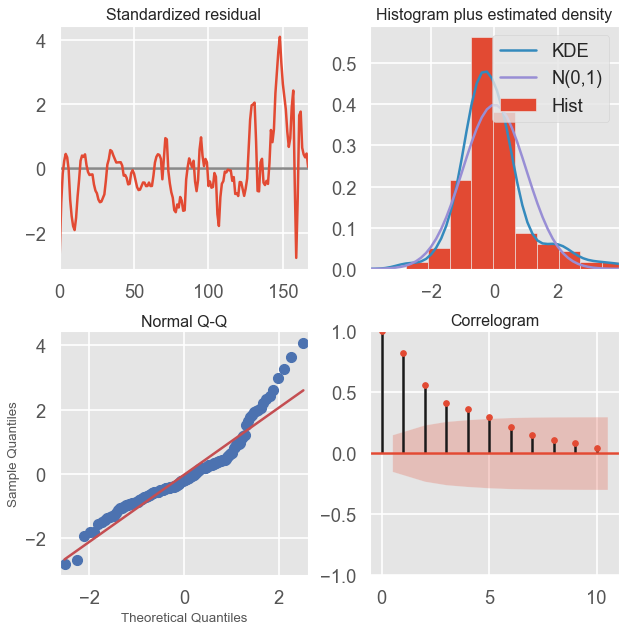

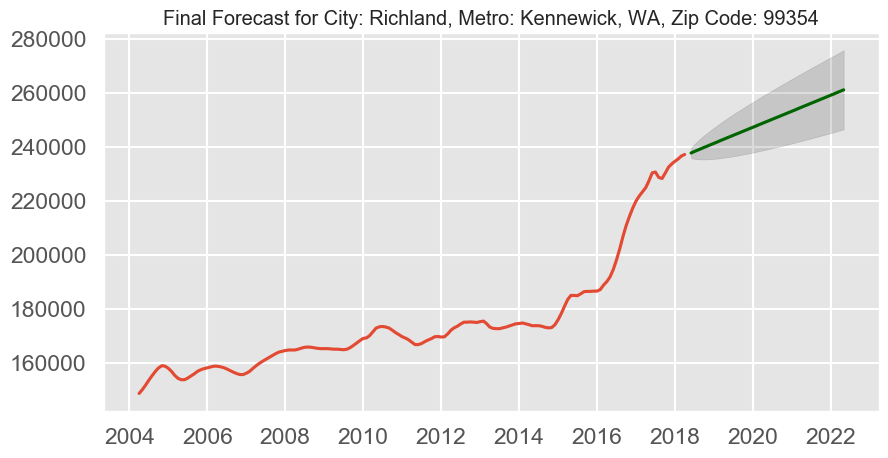

City: Richland, Metro: Kennewick, WA, Zip Code: 99354
Model Order:  (1, 1, 1)
Upside case 2022:  275669.96519838134 ROI:  16.001057755532546
Base Case 2022:  261030.62297504506 ROI:  9.840868409079185
Low case 2022:  246391.28075170875 ROI:  3.6806790626258086

--------------------------------------------------------------------------------

City: Richland, Metro: Kennewick, WA, Zip Code: 99352
Zip: 99352
ADF Statistic Residual: -5.425640
p-value: 0.000003


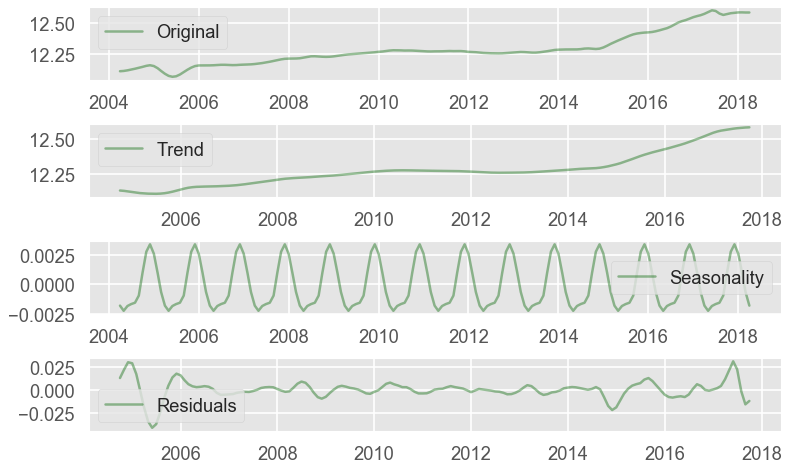

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2937.971, BIC=2950.467, Fit time=0.254 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2938.214, BIC=2944.462, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2945.950, BIC=2955.322, Fit time=0.071 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2939.354, BIC=2948.725, Fit time=0.091 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2962.575, BIC=2978.195, Fit time=0.283 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2940.076, BIC=2955.695, Fit time=0.233 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=3002.024, BIC=3020.768, Fit time=0.281 seconds
Total fit time: 1.227 seconds

_______________________________________________________________________________

City: Richland, Metro: Kennewick, WA, Zip Code: 99352
                           Statespace Model Results                           
Dep. V

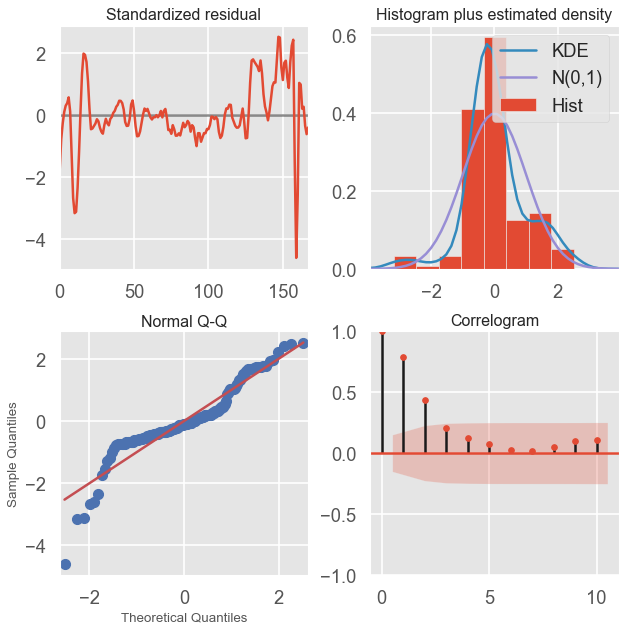

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [80]:
plt.style.use('ggplot')
#create an empty list for our residuals
residuals_list = []

for z in zip_list:
    df_z = zip_ts[zip_ts.ZipCode==z]
    ts = df_z.value
    
    decomposition = seasonal_decompose(np.log(ts))
    
    # Isolate the trend, seasonality and residuals of decomposed data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    df_z['res'] = residual
    residuals_list.append(residual)
    
    # Plot the decomposed data objects
    plt.figure(figsize=(10,6))
    plt.subplot(411)
    plt.plot(np.log(ts), label="Original", color="darkgreen", alpha=0.4)
    plt.legend(loc="best")
    plt.subplot(412)
    plt.plot(trend, label="Trend", color="darkgreen", alpha=0.4)
    plt.legend(loc="best")
    plt.subplot(413)
    plt.plot(seasonal, label="Seasonality", color="darkgreen", alpha=0.4)
    plt.legend(loc="best")
    plt.subplot(414)
    plt.plot(residual, label="Residuals", color="darkgreen", alpha=0.4)
    plt.legend(loc="best")
    plt.tight_layout()
    result = adfuller(residual.dropna())
    print('\n--------------------------------------------------------------------------------\n')
    print(titles_dict.get(z))
    print("Zip:", z)
    print("ADF Statistic Residual: %f" % result[0])
    print('p-value: %f' % result[1])
    plt.show()
    
    model = pm.auto_arima(df_z.value.dropna(), start_p=1, start_q=1,
                         test = 'adf',           # Use the ADF test to find the optimal d parameter
                         max_p = 10, max_q = 10, # Set max for p and q
                         m = 1,                  # Frequency of the series
                         d = None,               
                         seasonal = True, 
                         start_P = 0, 
                         D = None, 
                         trace = True, 
                         error_action = 'ignore', 
                         suppress_warnings = True, 
                         stepwise = True)
    print('\n_______________________________________________________________________________\n')
    print(titles_dict.get(z))
    print(model.summary())
    model.plot_diagnostics(figsize=(8, 8))
    plt.tight_layout()
    plt.show()
    
    #==================== Plot Train and Test =====================
    #df_z.reset_index(inplace=True)
    train = df_z.value.dropna()    # 
    #test = df_z.value.dropna()[145:]     # split at 2016-05 onwards for test
    
    #test_index = zip_ts.index[-24:]
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit()
    fc, se, confint = fitted.forecast(48, alpha=0.5)
    
    # Forecast
    #fc, se, conf = fitted.forecast(24, alpha=0.5) # 95% conf level
    
    # Make as Pandas Series
    #fc_series = pd.Series(fc, index=test_index)
    #lower_series = pd.Series(conf[:, 0], index=test_index)
    #upper_series = pd.Series(conf[:, 1], index=test_index)
    
    # Plot
    #plt.figure(figsize=(10,5), dpi=100)
    #plt.plot(train, label="Training")
    #plt.plot(test, label="Actual")
    #plt.plot(fc_series, label="Forecast")
    #plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=.15)
    #plt.title('Forecast vs. Actuals')
    #plt.legend(loc="best", fontsize=8)
    #plt.show()
    
    #print('MSE: {}'.format(((fc_series - test)**2).mean()))
    
    #===================== Plot Forecast ======================
    #df_z.reset_index(inplace=True)
    n_periods = 48
    fc, confint = model.predict(n_periods = n_periods, return_conf_int=True)
    #index_of_fc = np.arange(len(df_z.value), len(df_z.value)+n_periods)
    index_of_fc = pd.date_range('2018-05-01', periods=48, freq="M")
    
    # Make into Series for plotting
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))
    
    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(fc_series, color="darkgreen")
    plt.plot(df_z.value)
    plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=.15)
    plt.title("Final Forecast for {}".format(titles_dict.get(z)))
    plt.show()
    print(titles_dict.get(z))
    print("Model Order: ", model.order)
    print('Upside case 2022: ', upper_series[-1], 'ROI: ', (upper_series[-1]-fc_series[-48])/fc_series[-48]*100)
    print("Base Case 2022: ", fc_series[-1], 'ROI: ', (fc_series[-1] - fc_series[-48])/fc_series[-48]*100)
    print("Low case 2022: ", lower_series[-1], 'ROI: ', (lower_series[-1]-fc_series[-48])/fc_series[-48]*100)

# **Conclusion**

Based on the above, we found the model results for the **second parameter tunning settings** to produce more valid results. The following results are an interpretation and summary of finding based on the final approach (2nd option) model deployment.

## Summary of Findings:

###  City: Richland, Metro: Kennewick, WA, Zip Code: 99354

- **AIC:** 2803.545
- **MSE:** 765649501
- **Model Coefficients:** all statistically significant
- **Forecast in 2022:**
    - **Best Case Scenario ROI:** 16.00%
    - **Forecasted Base Case ROI:** 9.84%
    - **Lower Case Scenario ROI:** 3.68%

*Interpretation: The actuals (test data) or observed data far out-performed the forecast data in terms of the overall growth/increase in median housing prices. While 2017 and 2018 housing prices grew much larger than predicted, the ROI estimates confirm this would be a worthwhile zip code to invest in real estate.* 


### City: Richland, Metro: Kennewick, WA, Zip Code: 99352

- **AIC:** 2937.971
- **MSE:** 250374798
- **Model Coefficients:** ar.L1 and ma.L1 have high p-values and are not statistically significant
- **Forecast in 2022:**
    - **Best Case Scenario ROI:** 17.07%
    - **Forecasted Base Case ROI:** 9.93%
    - **Lower Case Scenario ROI:** 2.79%

*Interpretation: Improvements can be made to normalizing the residuals, which might improve the accuracy of the model predictions and the statistical significance of the model summary coefficients. Regardless, the forecast trend shows an upward linear growth is expected, as indicated by the ROI scenarios.*

### City: Kennewick, Metro: Kennewick, WA, Zip Code: 99336

- **AIC:** 2757.778
- **MSE:** 355482740
- **Model Coefficients:** all coefficient are statistically significant
- **Forecast in 2022:**
    - **Best Case Scenario ROI:** 16.13%
    - **Forecasted Base Case ROI:** 9.896%
    - **Lower Case Scenario ROI:** 3.66%

*Interpretation: Would like to see improvements to the normalization of the residuals. MSE is quite high, as the actual data was much, much higher than the predicted values based off our model. Continuously increasing growth is expected over the next 4 years, even at the lower limit of out confidence intervals. Investment in this zip code is expected to return steady growth.*

### City: Jefferson, Metro: Salem, OR, Zip Code: 97352

- **AIC:** 2656.483
- **MSE:** 182851943
- **Model Coefficients:** all show statistical significance
- **Forecast in 2022:**
    - **Best Case Scenario ROI:** 156.17%
    - **Forecasted Base Case ROI:** 43.49%
    - **Lower Case Scenario ROI:** -69.18%

*Interpretation: Residuals assumed a normal distribution, and our prediction matched closely to the observed values. However, the minimums within our confidence interval assume a negative trend unlike the 4 previous zip codes assessed. In essence, the forecast for housing price changes over the next 4 years are exposed to a bigger range of uncertainty in terms of expected increased growth. There is a chance of negative returns, while the base and optimistic ROIs are might higher. *

### City: Pasco, Metro: Kennewick, WA, Zip Code: 99301

- **AIC:** 2936.321
- **MSE:** 37842040
- **Model Coefficients:** all show statistical significance
- **Forecast in 2022:**
    - **Best Case Scenario ROI:** 21.898%
    - **Forecasted Base Case ROI:** 12.49%
    - **Lower Case Scenario ROI:** 3.09%

*Interpretation: Improvements can be made to normalization of residuals. Prediction performed closer to actual values, and forecasted values show an upward trend with confidence interval limits also upward trending. Steady growth in housing prices can be expected in this zip code over the next 4 years.*

## Future Considerations

- Complement or enhance this analysis with other economic and socio-economic data, including:
    - income projections, 
    - demographic changes (fertility rate and population growth), 
    - quality of life considerations (pollution rates, congestion/traffic, public transport availability, education, access to green spaces, etc.)
    - local tax policies and/or incentives/subsidies for home ownership
- Additional SARIMA Parameter tuning to improve accuracy of forecasting for:
- Closer examination and perhaps additional techniques to normalize the residuals for some zip codes.